In [2]:
from typing import List, Dict, Any, Optional, Union
import pandas as pd
import networkx as nx

from tqdm import tqdm
from time import time
from rdflib import Graph, URIRef, Literal, Namespace
from pathlib import Path
from operator import itemgetter
from matplotlib import pyplot as plt
from rdflib.namespace import XSD, RDF, RDFS, SKOS

from rdflib.extras.external_graph_libs import *

Visualizing the graph may improve our understanding of the data in the graph. The IReC GitHub repository contains some instructions for visualizing the graph with GraphDB. The `unfeatured_graph.ttl` file probably contains the most appropriate level of information for visualizing our graph. 

In this notebook, we would like to analyse the graph to identify potential concepts. The idea being that they could be added to a manually curated AEC conceptualization. For analysis, we'll use the `featured_graph.ttl` file.

We'll look at some basic graph analysis approaches:
* **Paths** we could be interested in, e.g.;
  * X constitutes Y constitutes Z etc
  
* Finding **central nodes** based, e.g.;
  * which nodes are likely common high-level classes, e.g., materials, systems, etc. (would we want to reweigh phrasese that contain such words?)
  * features that we could consider include the degree (number of edges for a node), betweennes (number of shortest paths that pass through the node), and 'page rank' (importance of node based on importance of related nodes)
      * concept-concept shortest paths may identify related terms, e.g., determine spans that connect the concepts `fire doorset` and `protected corridor`
      * betweennes centrality may suggest high level concepts, e.g., `materials`, `systems` and so on
      * page rank; which spans are connected to the most influential spans (ones with high betweennes or connected direclty to concepts)
* **Community detection**; find groups of closely connected nodes, e.g., we'd like to find all nodes that are directly related to spans revolving around materials. Approaches to use include Label propagation and Unfolding (Louvain) to compute a bottom-up grouping of connected nodes.

To do:
* continue exploring SPARQL + networkX combinations
  * weighted graph?
* wikiClassLabel; turn into an edge with a span as its representation 
check out how to create useful aggregate queries in SPARQL
* For now, we'll avoid looking at pattern matching through worst case optimal join (WCOJ) algorithms.

Add to requirements.txt:
* scipy==1.8
* networkx==3.0

In [2]:
graph_output_fp = Path.cwd().joinpath("data", "graph_output")

In [3]:
IREC_spans_URL = "https://spans.irec.org/"
IREC_concepts_URL = "https://concepts.irec.org/"

### Load Graph

In [4]:
irec_graph = Graph()
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
irec_graph.parse(graph_data_fp.joinpath("IREC.rdf"))

<Graph identifier=N65817d2355a24922bb03760a5645e32d (<class 'rdflib.graph.Graph'>)>

In [5]:
irec_graph.parse(graph_output_fp.joinpath("unfeatured_graph.ttl"))
UG = rdflib_to_networkx_graph(irec_graph)

In [7]:
# convert to NetworkX graph
irec_graph.parse(graph_output_fp.joinpath("featured_graph.ttl"))
FG = rdflib_to_networkx_graph(irec_graph)
# G = rdflib_to_networkx_digraph(irec_graph)

## Combine SPARQL and graph computations (work in progress from here on)

### Multiple paths; weighted graph
* We could store the subject node UID and object node UID separately. This may be useful when working with concepts in more detail. We don't really need this now, because for spans the UID is simply a coversion: `urllib.parse.quote('span')`

In [8]:
def get_single_type_edges(graph: Graph, edge_type: str = "irec:constitutes"):
    """
        We'll treate every edge as a bidirectional relation for now
    """
    test_query = """
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object
    WHERE {
        ?subject_node PREDICATE|^PREDICATE ?object_node .
        ?subject_node rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
    }
    LIMIT 25000
    """.replace("PREDICATE", edge_type)
    return irec_graph.query(test_query)

In [9]:
edge_types = [
    "irec:constitutes",                    # exact word overlap
    "irec:isMorphologicallySimilarTo",     # similar words
    "irec:isSemanticallySimilarTo",        # similar contexts
    "irec:related",                        # manually grabbed from Approved documents indices
    "irec:hasAcronym",                     # acronyms are naive or index based, not very important 
    "irec:hasAntonym",                     # overlapping except for antonym
    "skos:related",                        # manually grabbed from Approved documents indices
    "skos:exactMatch"                      # the span has a concept with equivalent label
] 

In [10]:
edge_weights = [
    2,                    # exact word overlap
    1,                    # similar words
    1,                    # similar contexts
    10,                   # manually grabbed from Approved documents indices
    1,                    # acronyms are naive or index based, not very important 
    10,                 # overlapping except for antonym
    5,                    # manually grabbed from Approved documents indices
    10                    # the span has a concept with equivalent label
] 
maximum_distance = sum(edge_weights)

In [11]:
# REMOVE LIMIT FROM get_single_type_edges query; need to consider parallel execution here
distance_dict = {}
for edge_type, edge_weight in tqdm(zip(edge_types, edge_weights)):
    sparql_result = get_single_type_edges(irec_graph, edge_type)
    for r in sparql_result:
        if r.subject != r.object:
            subj = str(r.subject)
            obj = str(r.object)
            # figure out weights (will be distances in the graph actually, so high value is less related)
            if subj not in distance_dict:
                distance_dict[subj] = {obj : maximum_distance - edge_weight}
            else:
                if obj not in distance_dict[subj]:
                    distance_dict[subj][obj] = maximum_distance - edge_weight
                else:
                    distance_dict[subj][obj] -= edge_weight

8it [00:25,  3.20s/it]


In [12]:
network = nx.Graph()
network.add_weighted_edges_from([(s, o, w) for s, r in distance_dict.items() for o, w in r.items()])

In [ ]:
# mst = nx.minimum_spanning_tree(network)

In [ ]:
# plt.figure(figsize=(10, 10))
# nx.draw_networkx(mst, with_labels=True, node_size = 20)
# plt.show()

In [13]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(mst, with_labels=True, node_size = 20)
    plt.show()

In [14]:
def divide_into_communities(network: nx.Graph, existing_community: set = None, existing_community_idx: str = None):
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
       
    for idx, community in enumerate(louvain):
            
#         if not "party wall" in community:
#             continue
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > 50: # max size of community
#             print(f"Community [{new_idx}] of size {len(community)} will be split further")
            divide_into_communities(network.subgraph(community), 
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    

In [ ]:
divide_into_communities(network)

Community [0] of size 13, top 10 spans by degree:
0: regulations [95]
1: chemicals [44]
2: drainage [43]
3: boundaries [31]
4: state [26]
5: flow [23]
6: maintenance [20]
7: specimens [19]
8: discharge [14]
9: discharge pipe [13]


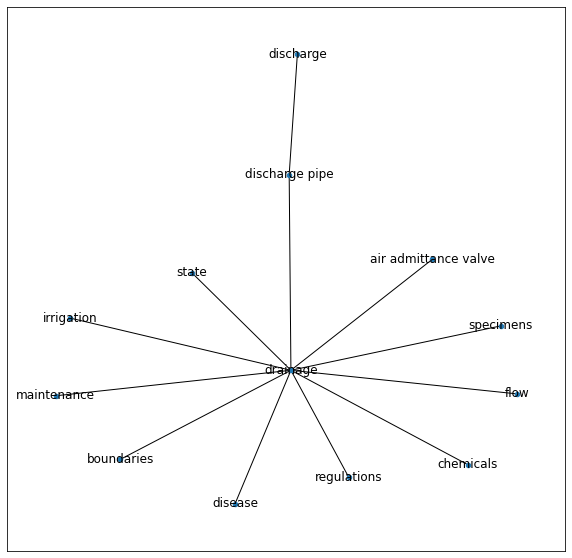

Community [1] of size 6, top 10 spans by degree:
0: underground drainage [16]
1: drainage positions [8]
2: mains drainage [7]
3: above - ground drainage system [6]
4: below ground drainage [5]
5: above ground drainage [5]


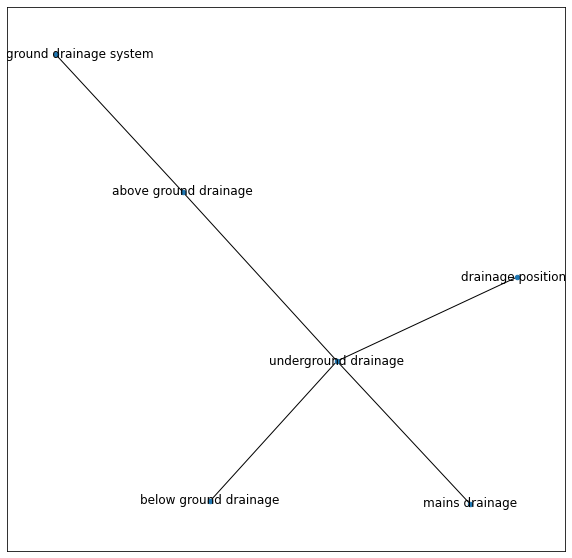

Community [2] of size 8, top 10 spans by degree:
0: Drainage [21]
1: Drainage of [7]
2: document Drainage [6]
3: subsoil drainage [4]
4: drainage pipe [4]
5: Drainage fields [4]
6: below-ground drainage [3]
7: drainage field [2]


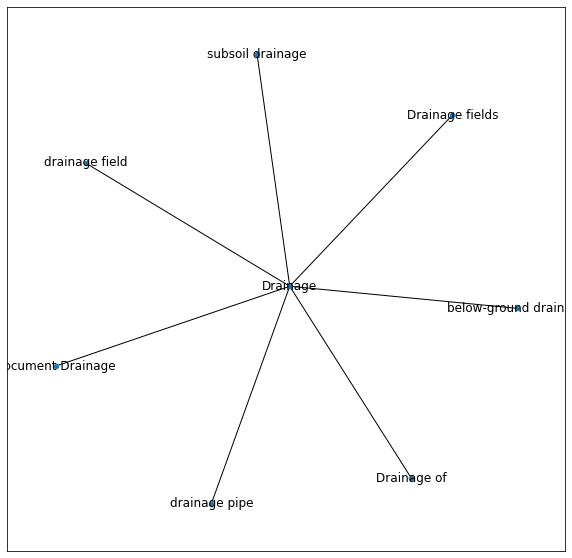

Community [3] of size 7, top 10 spans by degree:
0: foul water drainage [17]
1: water drainage [11]
2: drainage and water supply pipes [9]
3: foul water drainage system [9]
4: surface water drainage [6]
5: drainage pipes [5]
6: foul drainage system [5]


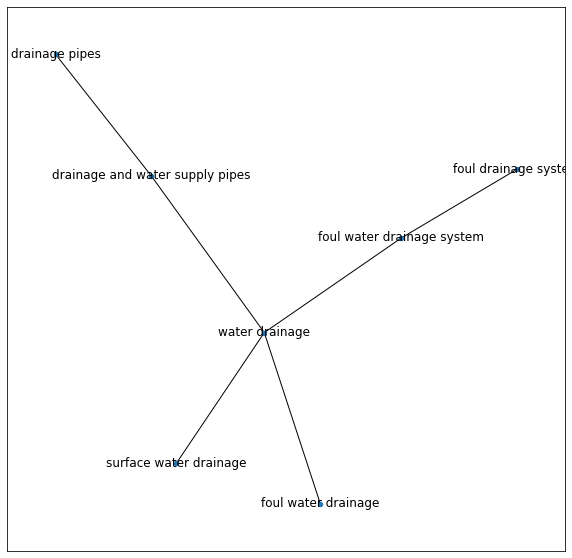

Community [4] of size 3, top 10 spans by degree:
0: underground rainwater drainage [12]
1: rainwater drainage [11]
2: rainwater drainage systems [10]


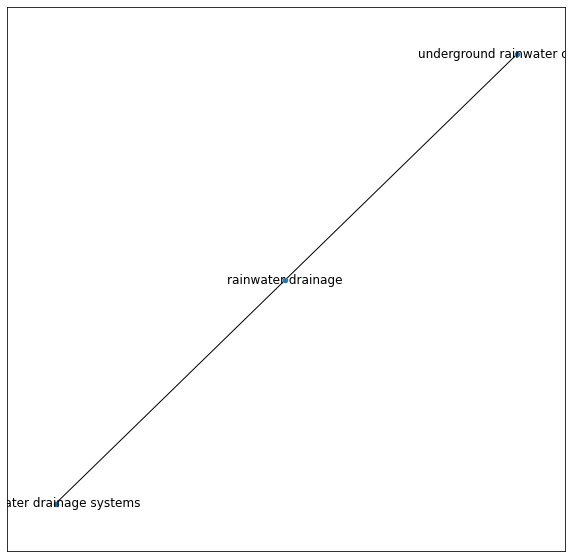

Community [5] of size 7, top 10 spans by degree:
0: surface water drainage systems [19]
1: drainage systems [14]
2: drainage system [12]
3: separate drainage systems [10]
4: Gravity drainage systems [9]
5: drainage fields [7]
6: drainage mounds [7]


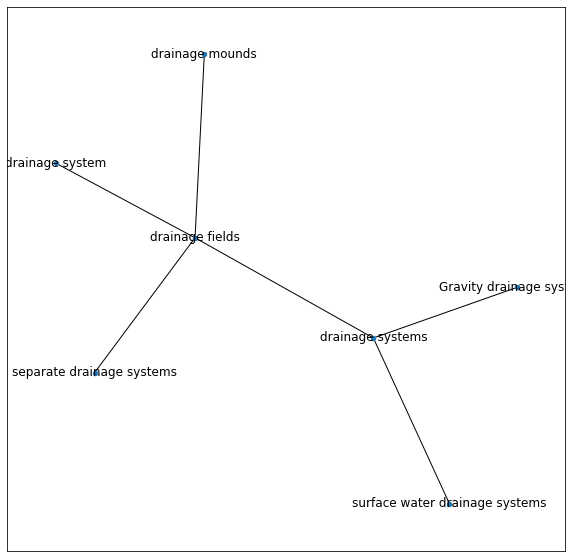

In [19]:
### TODO; pick a node in the graph and all of the nodes at distance X, then compute the communities
#  I don't think the radius works
divide_into_communities(nx.ego_graph(network, "drainage", radius=1))

Community [0] of size 41, top 10 spans by degree:
0: room [77]
1: stairs [65]
2: hall [32]
3: landing [27]
4: lobby [18]
5: kind structure [15]
6: concert halls [14]
7: residence [14]
8: All stairs [11]
9: entrance hall [11]


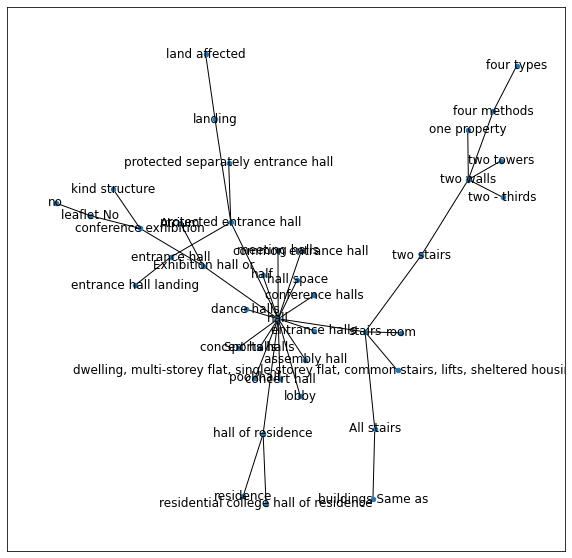

Community [0] of size 16, top 10 spans by degree:
0: compartment walls Fd Fire doorset [28]
1: Guild Steel Construction Institute [19]
2: frogged bricks [19]
3: openable windows NOTE [12]
4: UF ) foam systems [12]
5: bonded screed [9]
6: They failsafe [8]
7: Cracking [8]
8: screed [8]
9: Their failsafe system [8]


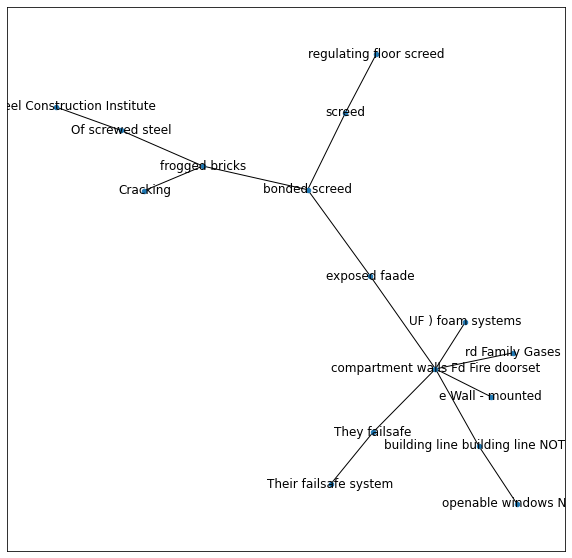

Community [1] of size 11, top 10 spans by degree:
0: flue [47]
1: Flue [33]
2: flue outlet [18]
3: flue outlet terminal [15]
4: flue blocks [12]
5: flues [11]
6: flue wall [7]
7: flue pipes [7]
8: flue walls [6]
9: wall flue [6]


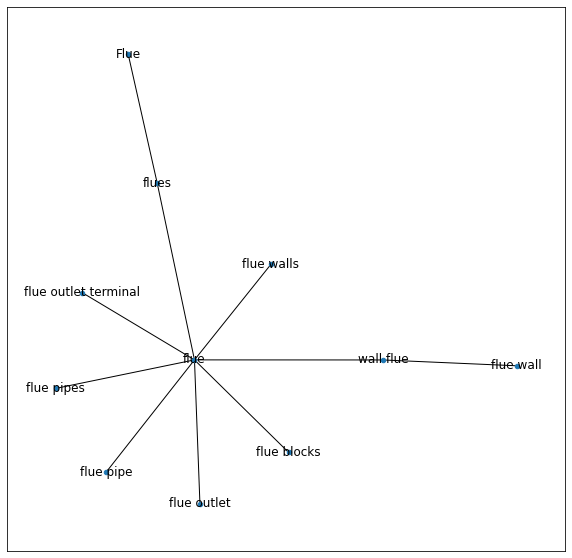

Community [2] of size 7, top 10 spans by degree:
0: mass [20]
1: flexible membrane [15]
2: plaster end use substrate [14]
3: mineral wool thickness [12]
4: wall leaf mass [9]
5: faecal matter [6]
6: deform [6]


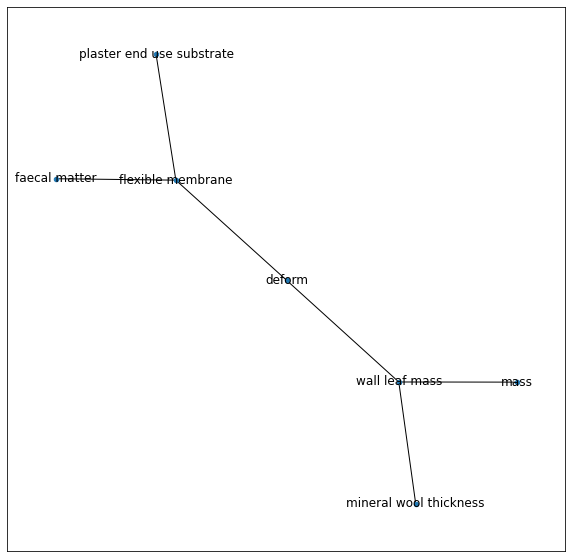

Community [3] of size 14, top 10 spans by degree:
0: Flexible [25]
1: Flue walls described [20]
2: Flues [16]
3: Fax orders [16]
4: Flue built [14]
5: Gullies [9]
6: Insurers [8]
7: Flueblocks [8]
8: isolating [7]
9: Flue wall Flue walls [7]


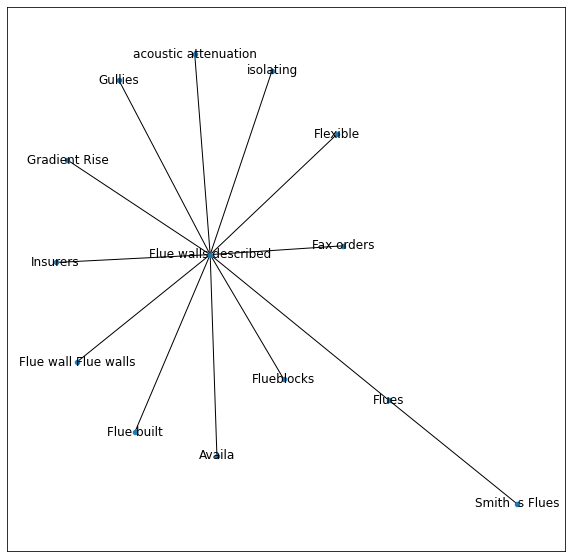

Community [4] of size 19, top 10 spans by degree:
0: application Internal fire spread linings [29]
1: protected stairways [21]
2: permanent air vent openings [19]
3: Transfer grilles wall [16]
4: permanently open air vents [13]
5: enclosed escalator wells [9]
6: protected lobbies [9]
7: upstands [9]
8: WC pans [8]
9: infilling blocks [8]


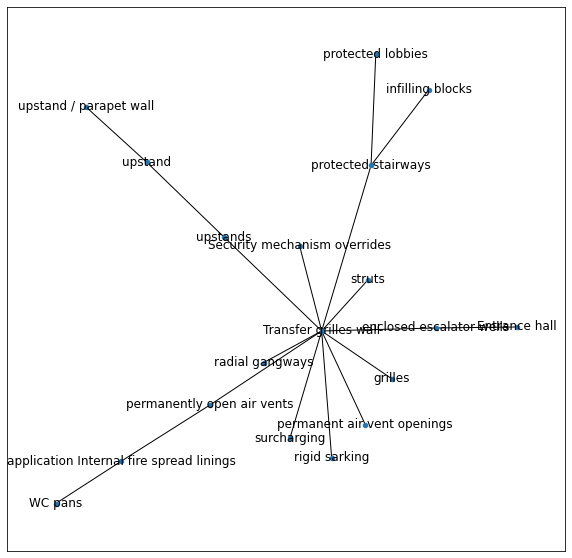

Community [5] of size 5, top 10 spans by degree:
0: Flueblock chimneys [14]
1: fluepipe Flues [12]
2: flueblock systems [9]
3: flueblock walls [6]
4: flueblock [5]


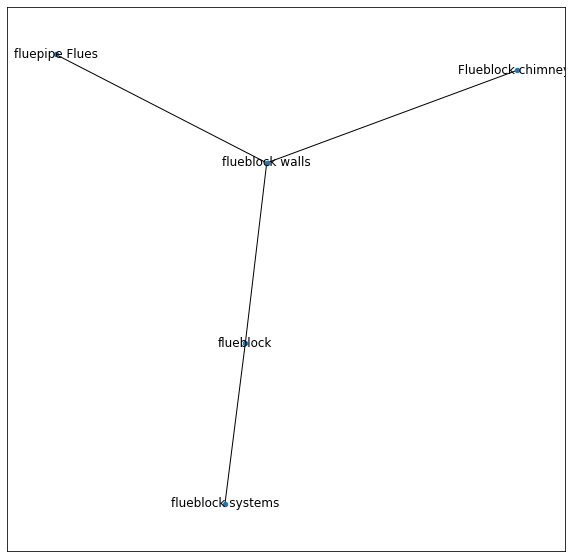

Community [6] of size 5, top 10 spans by degree:
0: side of building Diagram D6 [9]
1: Architraves [8]
2: architraves [4]
3: Archives [4]
4: architrave [2]


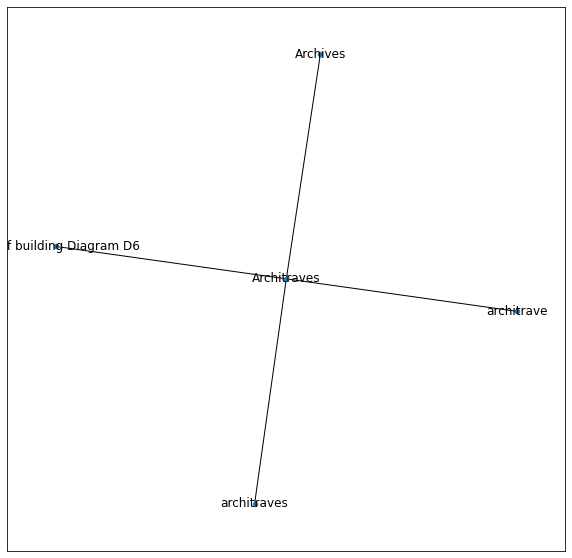

Community [0] of size 21, top 10 spans by degree:
0: insulator [46]
1: insulant [45]
2: Note : Insulation [13]
3: insulation criterion [13]
4: insulating core panel [8]
5: electrical insulation [8]
6: flexible insulation [7]
7: foamed insulation [6]
8: insulation standards [6]
9: insulation performance [6]


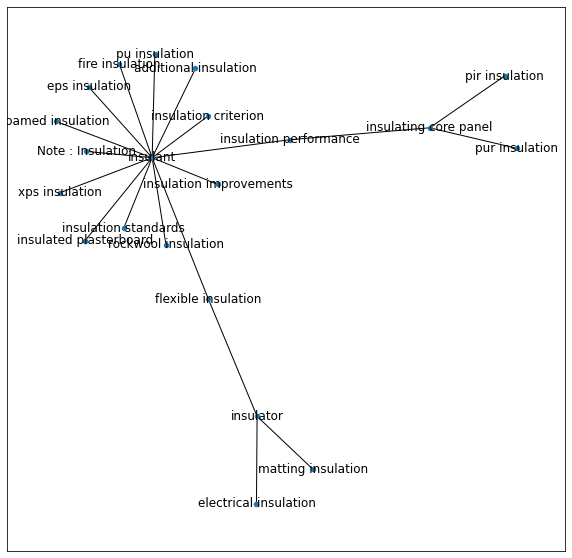

Community [1] of size 19, top 10 spans by degree:
0: insulation [79]
1: rigid insulation [11]
2: installation [10]
3: acoustic insulation [8]
4: polyurethane insulation [7]
5: expanded polystyrene polystyrene insulation [7]
6: foam insulation [7]
7: spray-applied insulation [6]
8: composite insulation [6]
9: polyisocyanurate insulation [6]


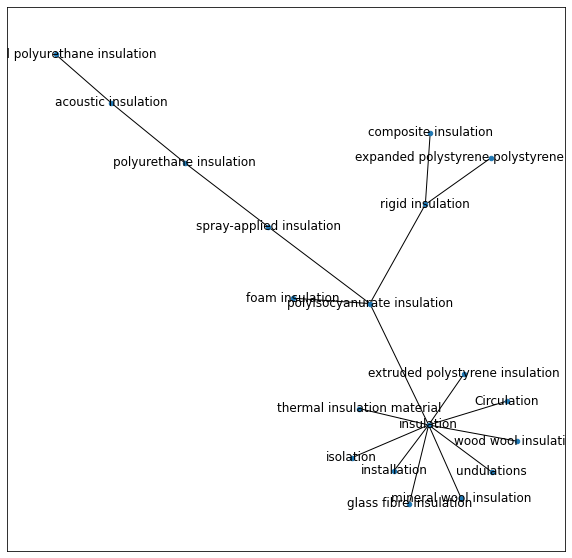

Community [2] of size 15, top 10 spans by degree:
0: thermal insulation [27]
1: sound insulation [15]
2: test insulation [15]
3: sound insulation values [13]
4: electrical wiring [13]
5: heat insulation [13]
6: sound insulation tests [12]
7: cavity insulation [11]
8: loft insulation [9]
9: terms of insulation [9]


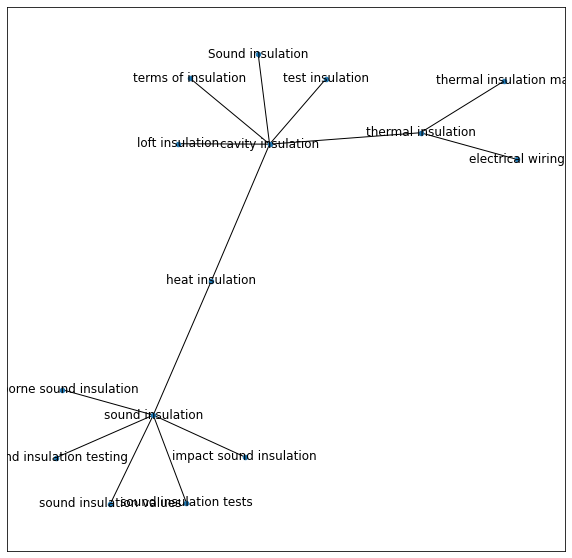

Community [3] of size 6, top 10 spans by degree:
0: layer [45]
1: insulation layer [7]
2: insulating layer [5]
3: insulation layers [5]
4: principal insulation layer [3]
5: Resilient layer insulation [3]


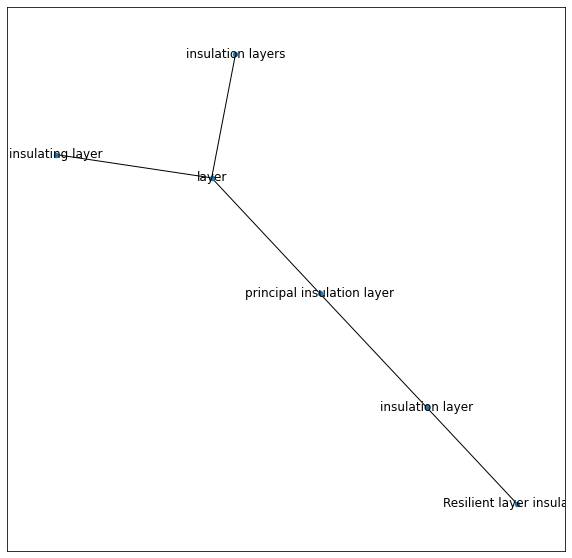

Community [4] of size 14, top 10 spans by degree:
0: productive [29]
1: products [29]
2: product [27]
3: insulating material [20]
4: thermally insulating [16]
5: smoke outlet [15]
6: insulation materials [14]
7: thermal insulants [12]
8: profiled insulated [10]
9: Thermoplastic insulation materials [10]


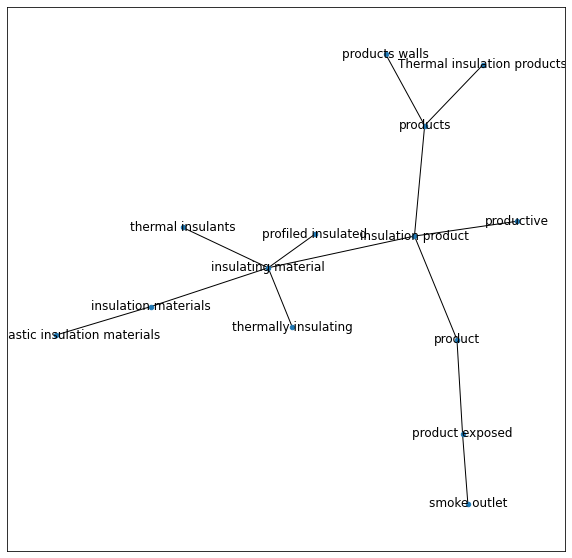

Community [3] of size 37, top 10 spans by degree:
0: ventilation [80]
1: dwelling [37]
2: CO2 [21]
3: whole dwelling ventilation rate [19]
4: rural dwelling house in [15]
5: maximum whole dwelling extract ventilation rate [11]
6: dwelling fabric energy efficiency rate [11]
7: whole dwelling extract ventilation rate [10]
8: whole dwelling supply ventilation rate [9]
9: whole dwelling ventilation supply rate [9]


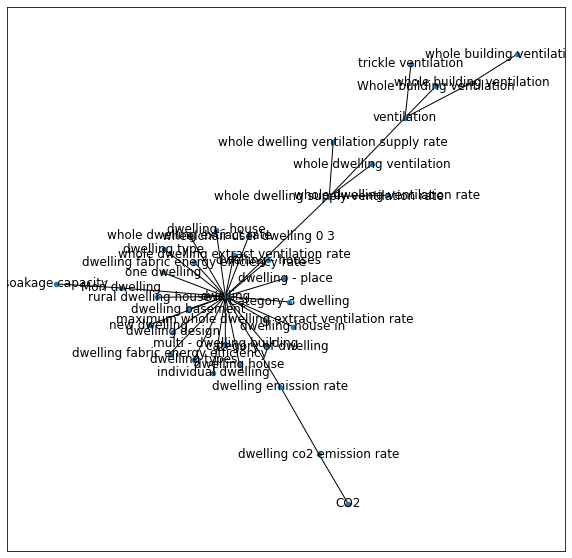

Community [0] of size 16, top 10 spans by degree:
0: A [53]
1: waste disposal Approved Document J Combustion appliances [40]
2: Compartment [31]
3: Communal [21]
4: Compartment wall floor A fire resisting wall [16]
5: Compartment wall [15]
6: Compartment wall Fd Fd External shaft A Protected shaft C [13]
7: compartment wall Compartment wall floor Flue Compartment Compartment wall wall [13]
8: Combustion appliances [12]
9: Membranes [11]


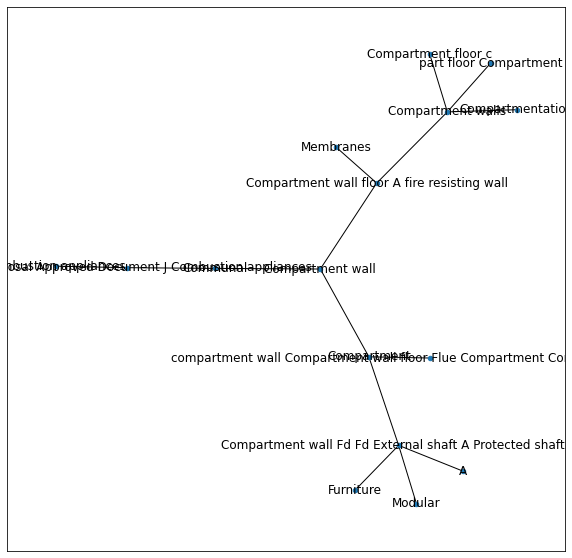

Community [1] of size 27, top 10 spans by degree:
0: compartment [73]
1: compartment wall [43]
2: cavity barrier [22]
3: building compartment [22]
4: compartment floor [20]
5: compartmented [19]
6: WC compartment doors [15]
7: objects compartment [15]
8: compartment walls [14]
9: compartment part [13]


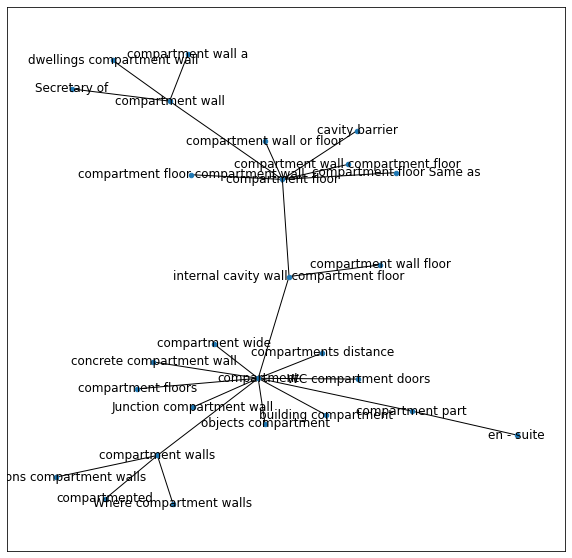

Community [2] of size 11, top 10 spans by degree:
0: bedroom [23]
1: bedrooms [19]
2: Bedroom [17]
3: Bedrooms [16]
4: joint [13]
5: headroom [13]
6: Every bedroom [9]
7: Every joint fit [8]
8: Bedroom doors [8]
9: first joint [7]


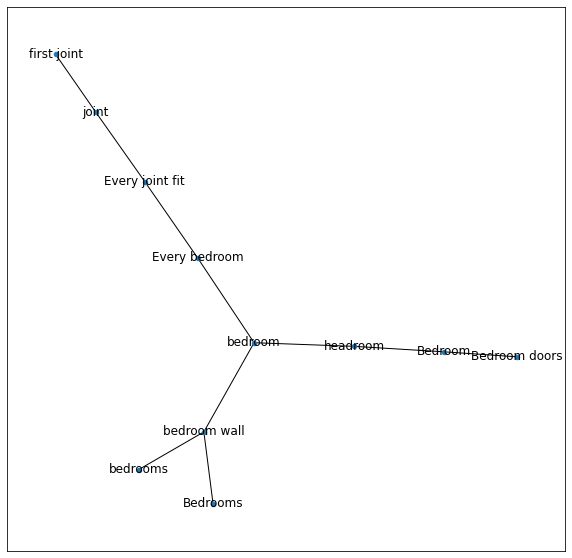

Community [3] of size 17, top 10 spans by degree:
0: cars [31]
1: rails [25]
2: difference [22]
3: cylinders [20]
4: exemption [19]
5: rest [15]
6: void [14]
7: telegraph [13]
8: waves [12]
9: trap [11]


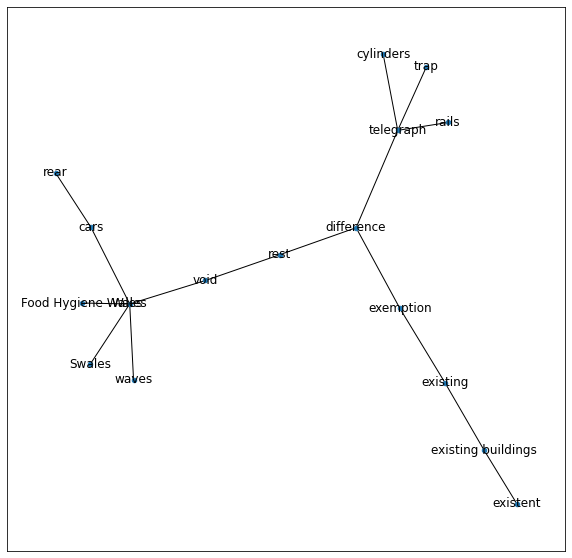

Community [0] of size 25, top 10 spans by degree:
0: timber [35]
1: Timber [27]
2: timbered [22]
3: full depth timber blocking [13]
4: laminate [13]
5: moisture [13]
6: timber - framed house [11]
7: timber raft [8]
8: timber blockings [8]
9: timber laminates [8]


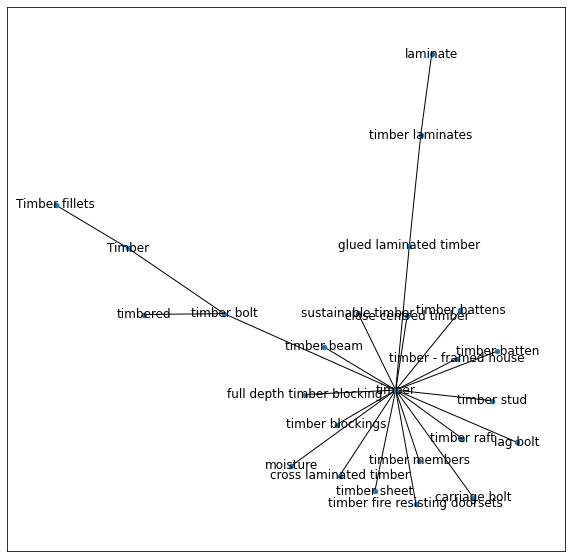

Community [1] of size 9, top 10 spans by degree:
0: support [27]
1: supported [20]
2: supports [19]
3: supportive [19]
4: supporting structure [16]
5: Lateral support [9]
6: supporting framework [9]
7: lateral support [8]
8: supported wall [7]


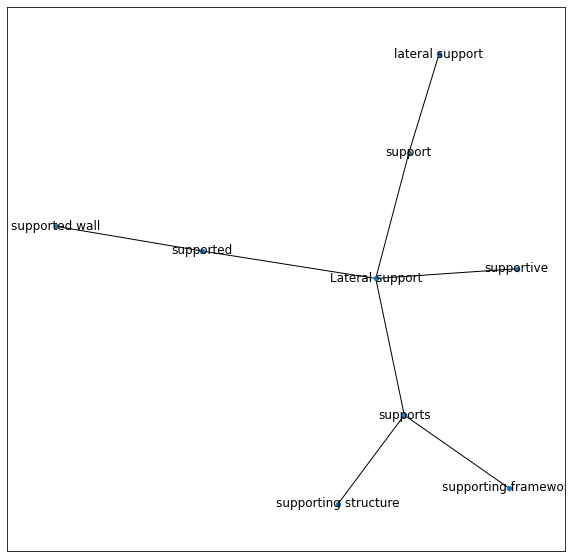

Community [2] of size 23, top 10 spans by degree:
0: structure [77]
1: structures [23]
2: structural walls [18]
3: separating structure [17]
4: concrete structures [15]
5: timber structures Part 1 1 : General Common rules [15]
6: structural design [15]
7: masonry structures [14]
8: structural frames [13]
9: component structure [11]


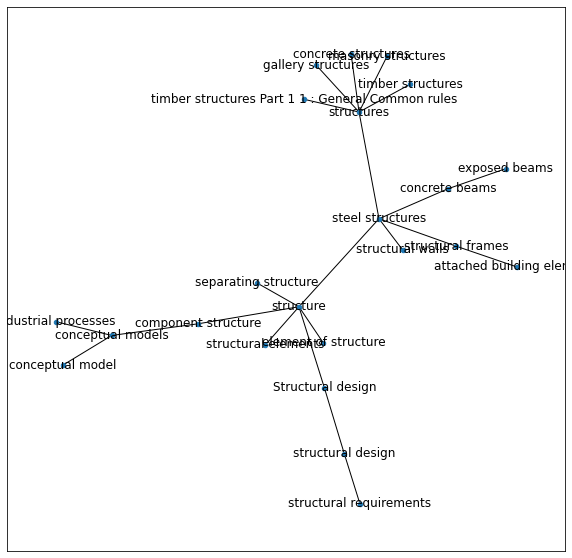

Community [3] of size 15, top 10 spans by degree:
0: steel [39]
1: copper [25]
2: cladding [18]
3: steel reinforced concrete [13]
4: wall cladding [11]
5: Timber cladding [10]
6: natural stone cladding [10]
7: external cladding systems [10]
8: aluminium [10]
9: cladding system [8]


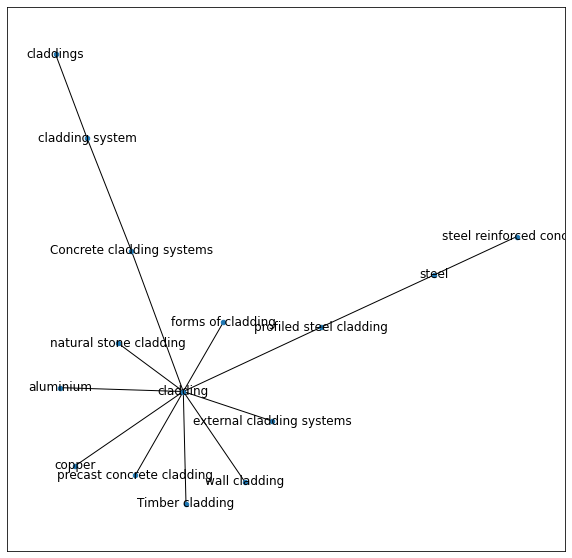

Community [4] of size 28, top 10 spans by degree:
0: frame [35]
1: frames [30]
2: framed [26]
3: flame [18]
4: metal frame [10]
5: portal frames [10]
6: framed construction [9]
7: structural frame [9]
8: sliding frame [8]
9: timber frame [8]


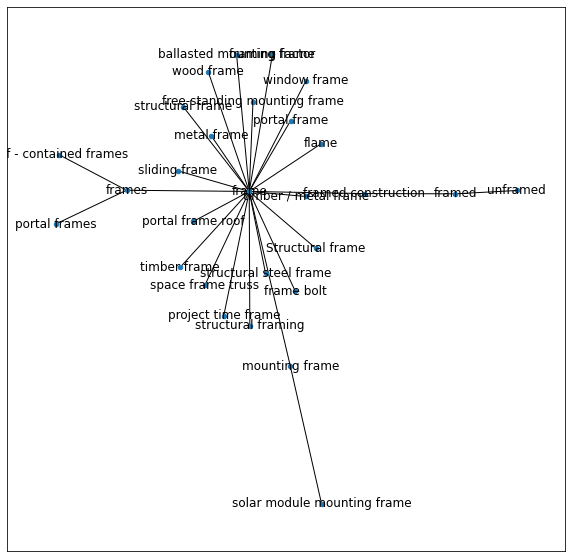

Community [6] of size 23, top 10 spans by degree:
0: load [38]
1: bearing [32]
2: Vertical [29]
3: boarding [27]
4: board [26]
5: Boarding [21]
6: vertical load [16]
7: load - bearing wall construction [12]
8: load - bearing [12]
9: covered [12]


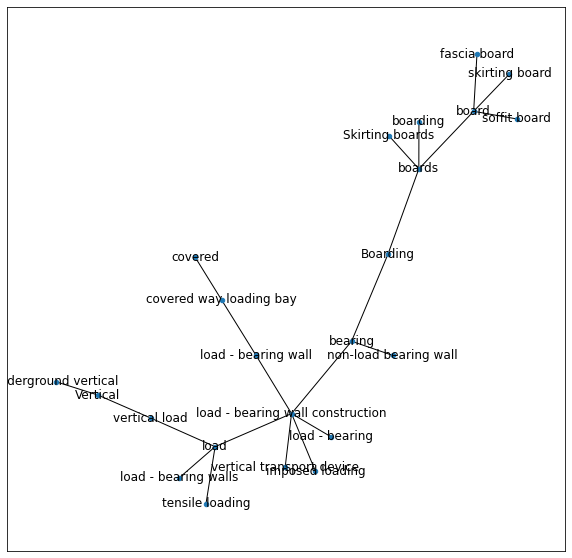

Community [0] of size 6, top 10 spans by degree:
0: concrete [32]
1: suspended concrete floor [13]
2: concrete floor [11]
3: floor slabs [7]
4: concrete floor slabs [6]
5: concrete slab floor [5]


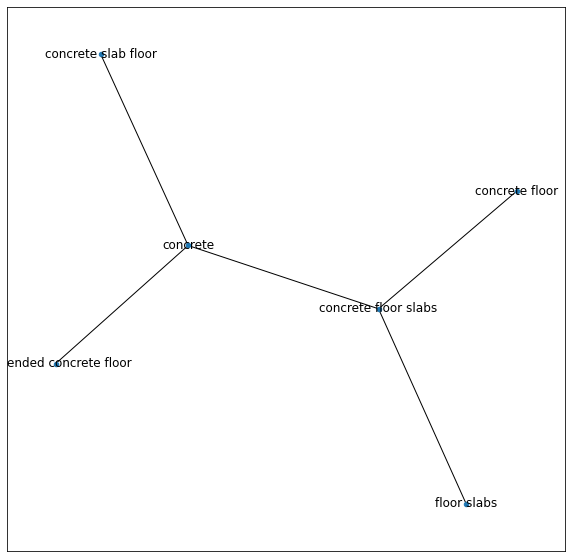

Community [1] of size 7, top 10 spans by degree:
0: floor load [27]
1: floor type [22]
2: floor space factors [14]
3: bedding types [13]
4: floor space [8]
5: floorings A1 [6]
6: floor space factor [4]


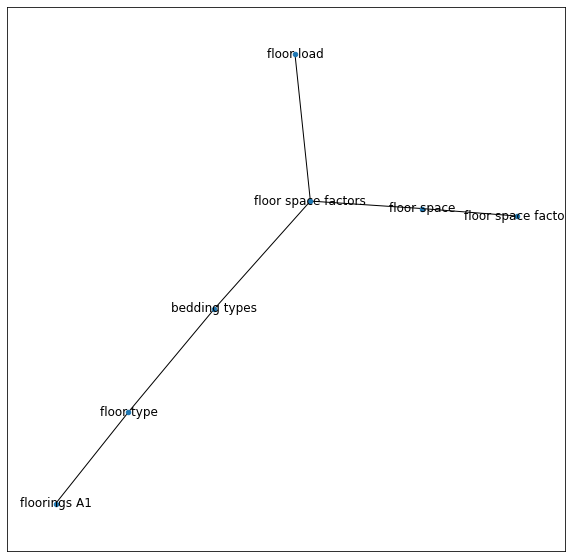

Community [2] of size 9, top 10 spans by degree:
0: height [35]
1: base [23]
2: walls level [19]
3: from floor [10]
4: floor base [9]
5: base floor [7]
6: floor levels [6]
7: flats height [6]
8: structural floor base [4]


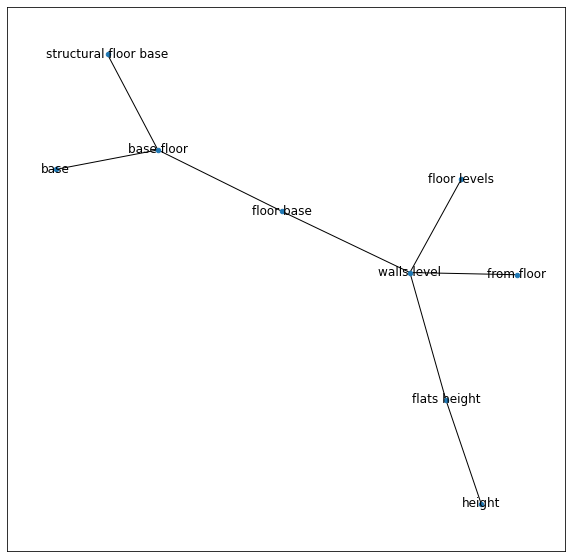

Community [3] of size 14, top 10 spans by degree:
0: floors [34]
1: wall floor [22]
2: compartment walls floors [21]
3: floors walls [20]
4: walls floor [17]
5: walls floors [12]
6: Walls floors [9]
7: floors connected [9]
8: wall First floor 1 [8]
9: compartment walls compartment floors [8]


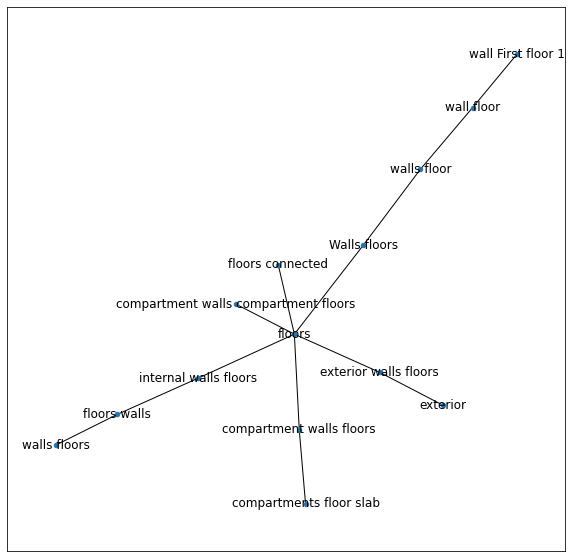

Community [4] of size 12, top 10 spans by degree:
0: covering [17]
1: structural floor cavity [16]
2: soft floor covering [11]
3: floor covering [10]
4: floor cavity [9]
5: sloping floor tier [9]
6: sloping floor [8]
7: separating floor separating wall [8]
8: Type of floor covering [8]
9: separating floor [7]


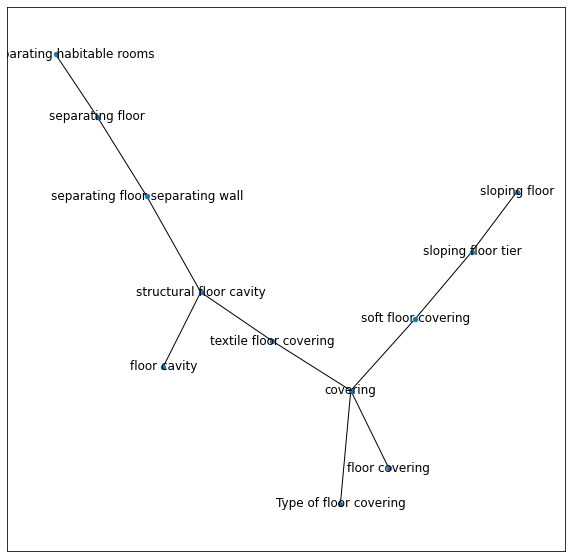

Community [5] of size 34, top 10 spans by degree:
0: floor [153]
1: level [67]
2: ground [45]
3: internal floor area [20]
4: floor level [16]
5: change floor level [15]
6: ground floor [14]
7: Clear floor space [13]
8: ground level [13]
9: building level Top ground [12]


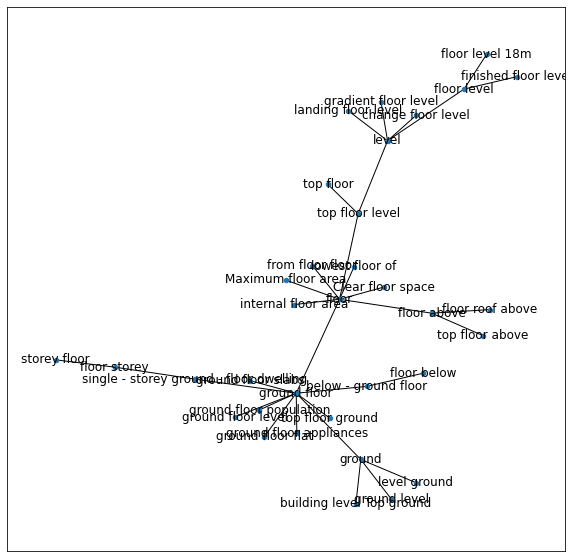

Community [6] of size 24, top 10 spans by degree:
0: b [67]
1: compartment wall floor b [37]
2: floor s [22]
3: tch roof ii [19]
4: floor treatment 2 [13]
5: gallery Ground [10]
6: cupboard Close cavity [9]
7: floor 10 [9]
8: two cupboards dwelling b [9]
9: room - sealed [8]


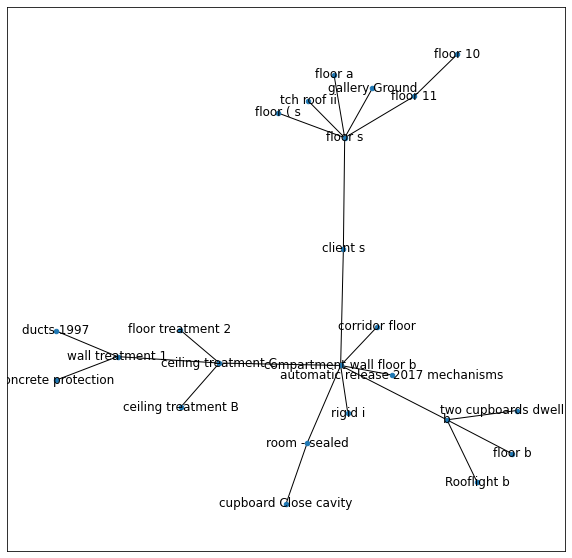

Community [7] of size 43, top 10 spans by degree:
0: flooring [109]
1: Flooring [103]
2: floored [100]
3: floor penetrations [20]
4: suspended floors [15]
5: floor structures [15]
6: floor REI 30  8 [14]
7: floor constructions [13]
8: floor repair [11]
9: floor REI [10]


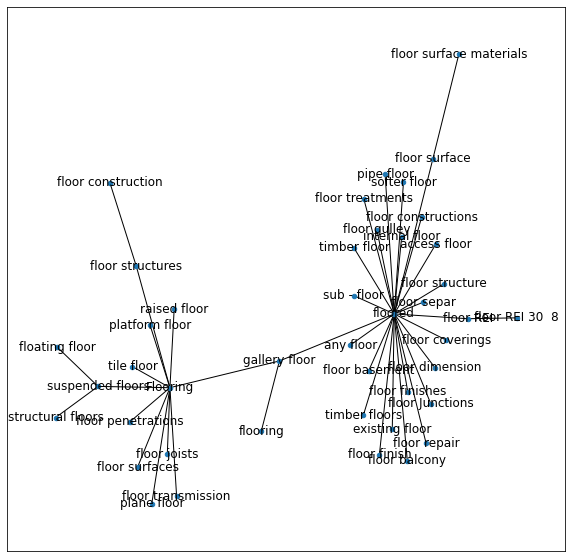

Community [8] of size 34, top 10 spans by degree:
0: surface [88]
1: surfaces [60]
2: leaf [30]
3: inner [21]
4: inner surface walls [13]
5: m width [12]
6: mm sphere [12]
7: leaves [11]
8: m centres [11]
9: lead [10]


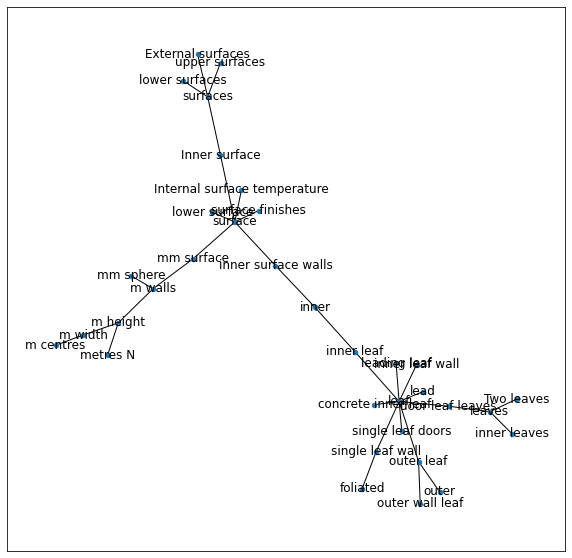

Community [9] of size 34, top 10 spans by degree:
0: canton of [31]
1: score [23]
2: color of [21]
3: Nrnberg [20]
4: apartment building [20]
5: cities squares [19]
6: Saillon [17]
7: Kentucky [17]
8: enclosure [15]
9: defensive wall [15]


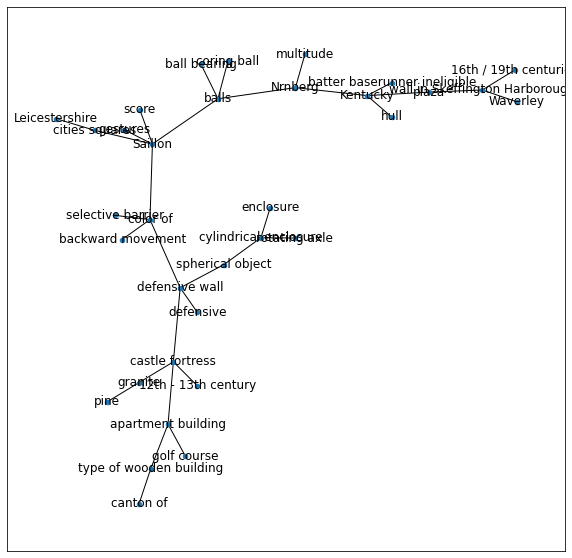

Community [0] of size 3, top 10 spans by degree:
0: lighting diffusers ceilings [18]
1: lighting diffusers [15]
2: lighting diffuser [14]


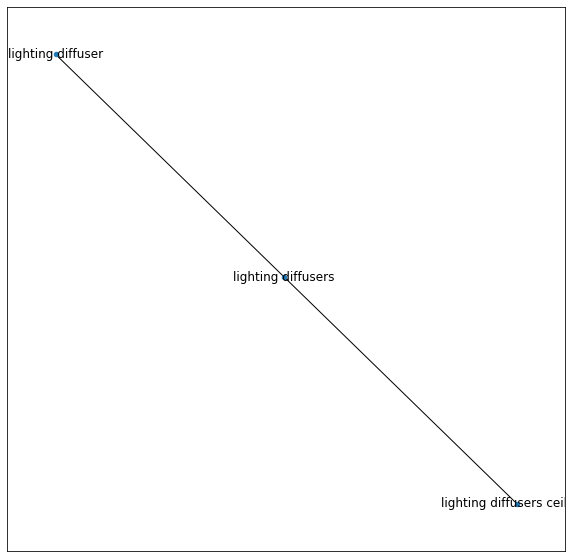

Community [1] of size 9, top 10 spans by degree:
0: plasterboard [18]
1: plasters [11]
2: gypsum [11]
3: plaster [11]
4: gypsum plasterboard end use [10]
5: plaster skim [9]
6: plasterboard finish [6]
7: Gypsum plasterboards [3]
8: plasterboard substrate [2]


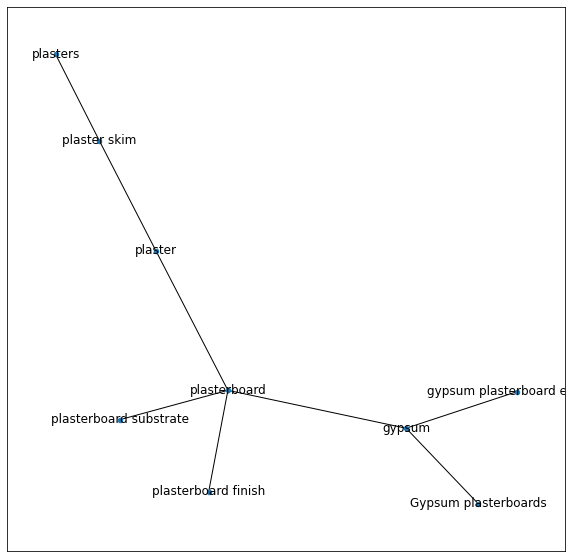

Community [2] of size 10, top 10 spans by degree:
0: tiling [36]
1: boiling [29]
2: cabling [28]
3: railing [24]
4: cooling [20]
5: willing [11]
6: Grab rails [9]
7: Piling [7]
8: piling [6]
9: uilding [4]


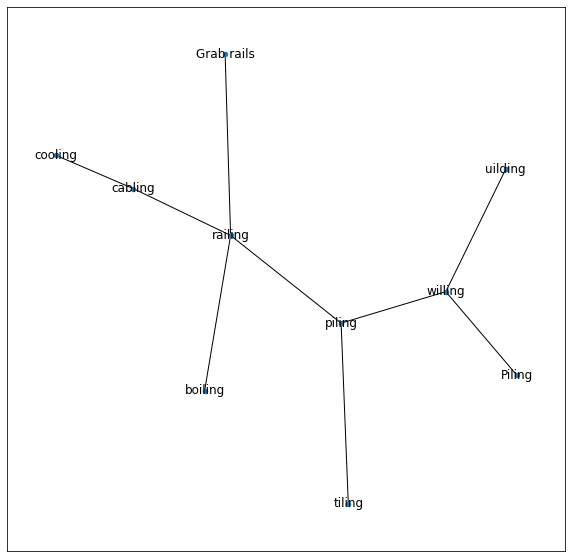

Community [3] of size 29, top 10 spans by degree:
0: ceiling [57]
1: Ceiling [42]
2: ceilings [29]
3: joist [18]
4: independent ceiling [14]
5: suspended ceiling [9]
6: wall ceiling surfaces [8]
7: wall ceiling [8]
8: ceiling wall [8]
9: zone ceiling [7]


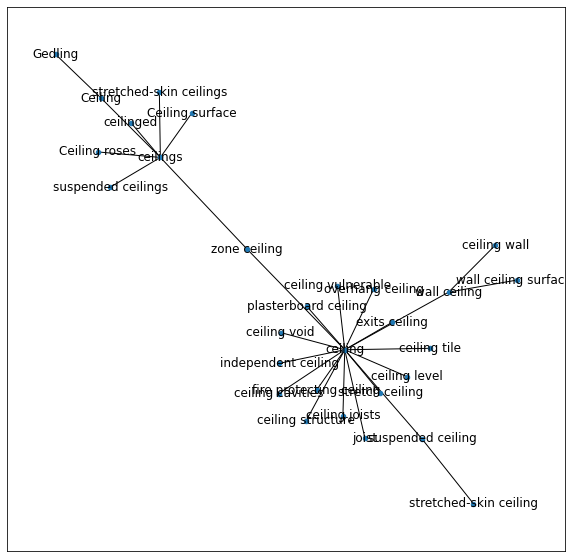

Community [4] of size 2, top 10 spans by degree:
0: ceiling class B - s3 d2 [15]
1: building Class d2 [8]


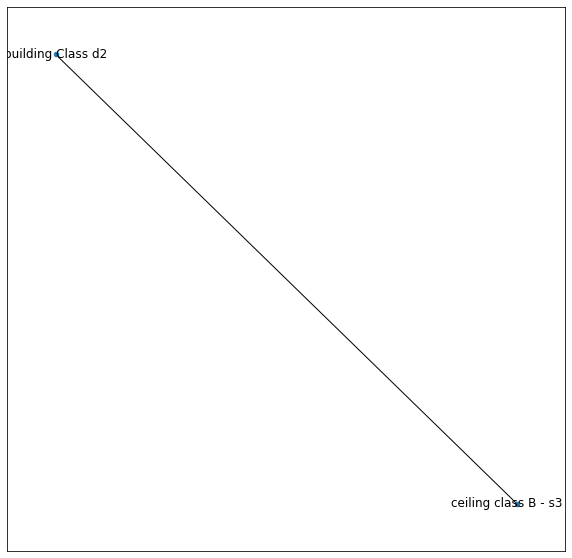

Community [5] of size 10, top 10 spans by degree:
0: witting [14]
1: warning [14]
2: WARNING [13]
3: wiring [12]
4: wired [9]
5: Waiting [8]
6: electric wiring [5]
7: steel wire [4]
8: wired glass [4]
9: wire cage [3]


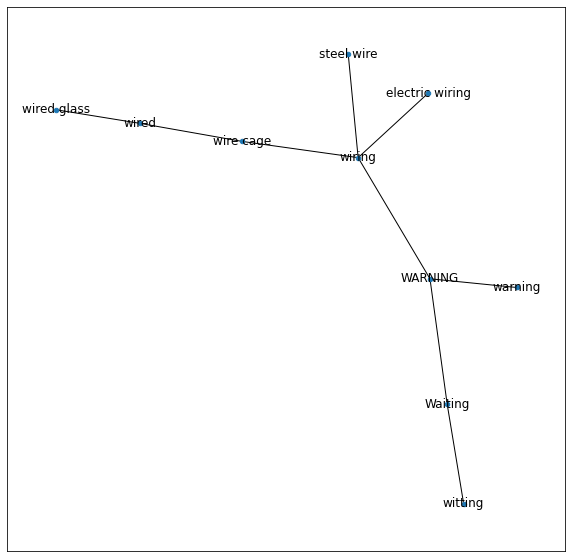

Community [6] of size 14, top 10 spans by degree:
0: linings [52]
1: lining [37]
2: lined [27]
3: Lines [25]
4: lining partition [20]
5: plasterboard linings [12]
6: ceiling linings [8]
7: paint [8]
8: wall linings [7]
9: building linings [7]


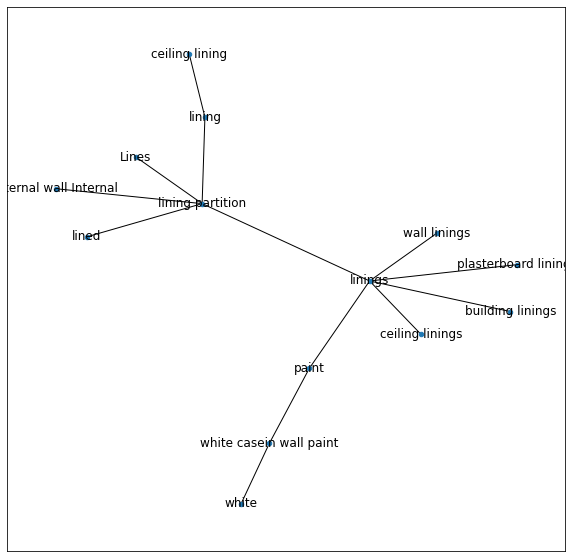

Community [0] of size 10, top 10 spans by degree:
0: galleries [47]
1: adjustment [40]
2: Safety [35]
3: Guide [27]
4: seats [26]
5: garage [12]
6: chair [5]
7: audio [5]
8: visitor [2]
9: visitors [2]


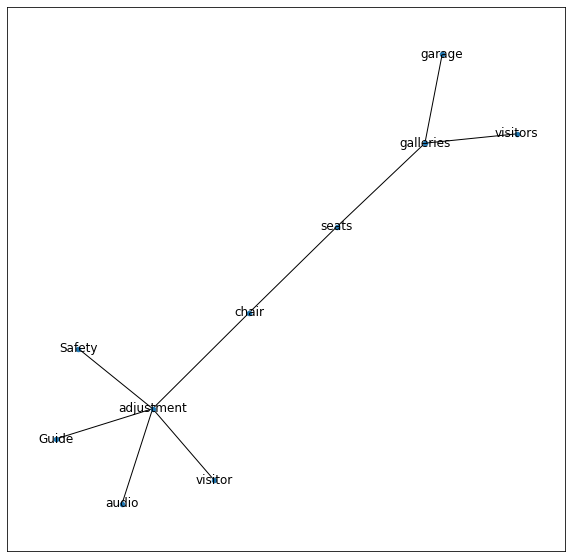

Community [1] of size 15, top 10 spans by degree:
0: cooker hood [31]
1: gallery [29]
2: kitchen [21]
3: shop [19]
4: restaurant [17]
5: Shop [13]
6: shop commercial [13]
7: carport [12]
8: TV aerial [8]
9: kitchen worktop [8]


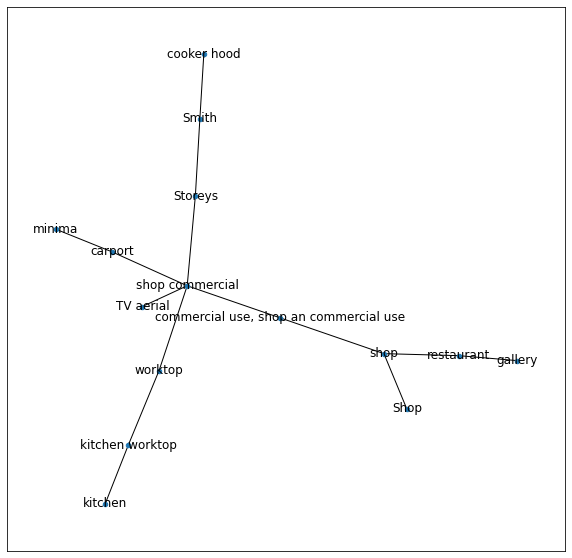

Community [2] of size 7, top 10 spans by degree:
0: ANY [18]
1: Any wall [9]
2: Any means [9]
3: Any gallery [9]
4: Any windows [8]
5: Any floor floor [7]
6: Any building element [7]


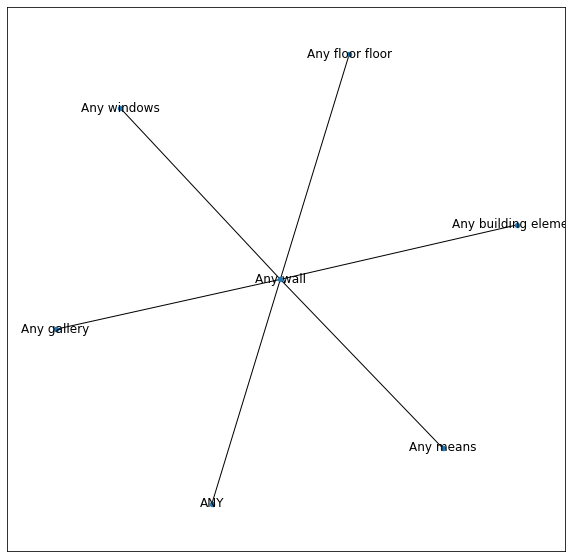

Community [3] of size 14, top 10 spans by degree:
0: open [72]
1: Open [52]
2: opening [36]
3: openings [20]
4: openable windows [18]
5: open windows [16]
6: window openings areas [10]
7: outward opening [8]
8: Purge ventilation window opening area [8]
9: window opening area [7]


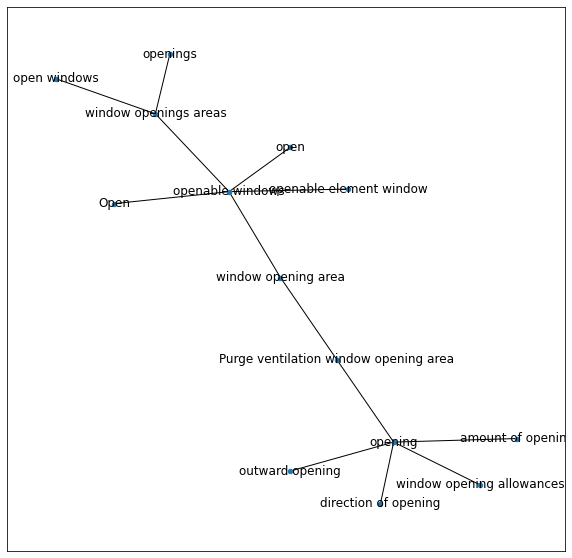

Community [4] of size 8, top 10 spans by degree:
0: hearth [10]
1: earth [9]
2: Hearths [7]
3: Hearth [7]
4: Earth [6]
5: earth closet [3]
6: alkaline earth metal [3]
7: earthly [3]


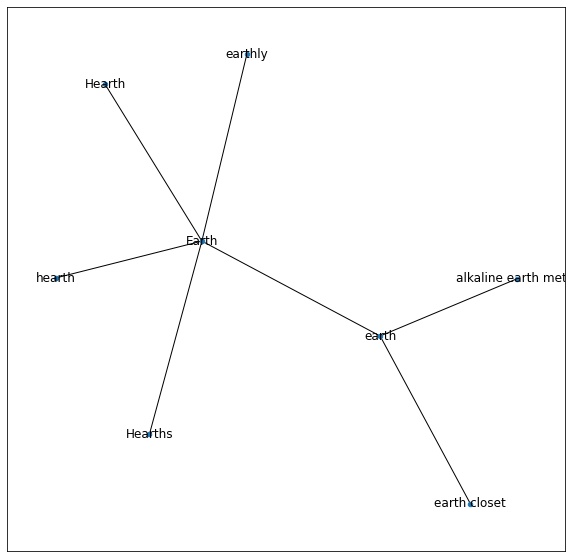

Community [5] of size 40, top 10 spans by degree:
0: window [81]
1: glazing [33]
2: windows [33]
3: Windows [30]
4: display windows [18]
5: escape windows [18]
6: security [14]
7: platform [12]
8: window door [10]
9: window glazing [10]


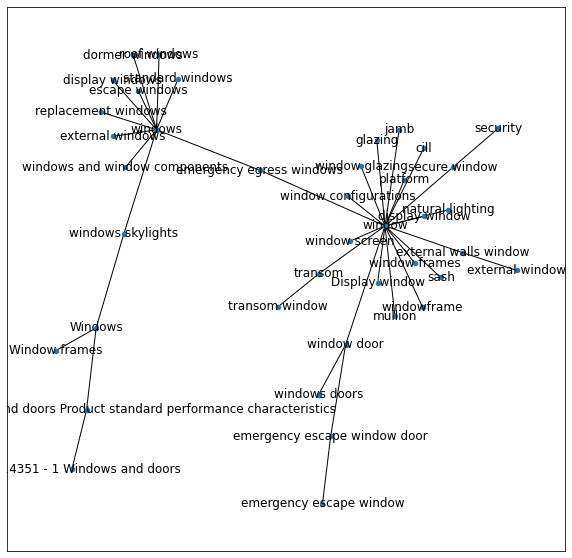

Community [6] of size 19, top 10 spans by degree:
0: rooms [46]
1: basin [42]
2: edges [37]
3: spaces [34]
4: Pressure [31]
5: shallow [17]
6: zones [16]
7: covers [14]
8: background [14]
9: adjoining [8]


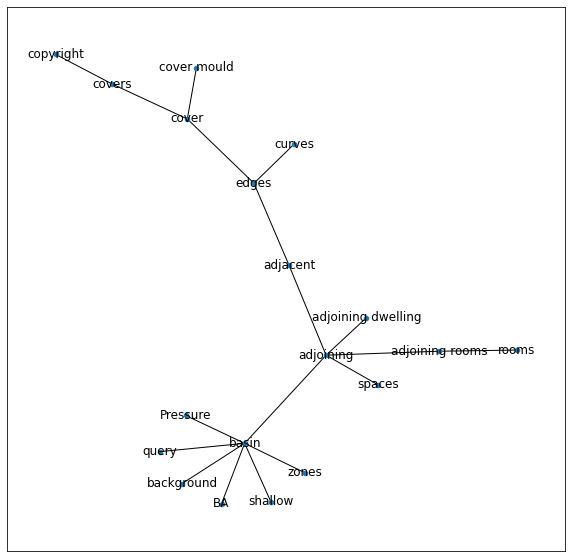

Community [0] of size 34, top 10 spans by degree:
0: pipe [66]
1: pipe fittings [29]
2: water supply [25]
3: protected shaft [23]
4: pipe size [23]
5: corridors [20]
6: discharge pipe [13]
7: discharge pipes [12]
8: Pipes [12]
9: Pipe fitting [11]


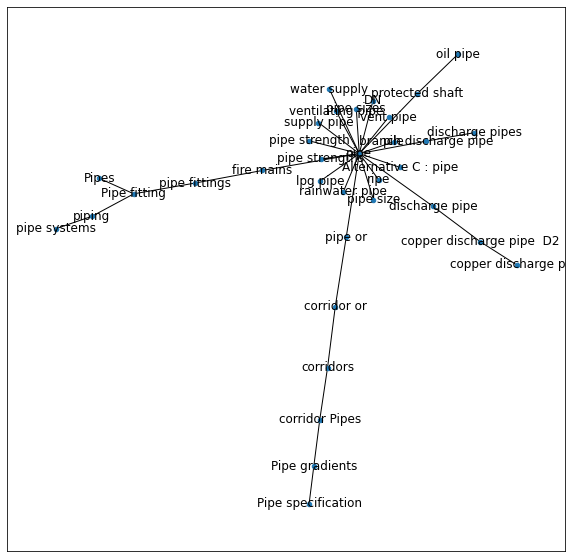

Community [1] of size 10, top 10 spans by degree:
0: living [20]
1: live [17]
2: combination [15]
3: combined [14]
4: living roof [12]
5: lime [10]
6: combinative [10]
7: living walls [6]
8: combination walls [6]
9: brick - fireplace [5]


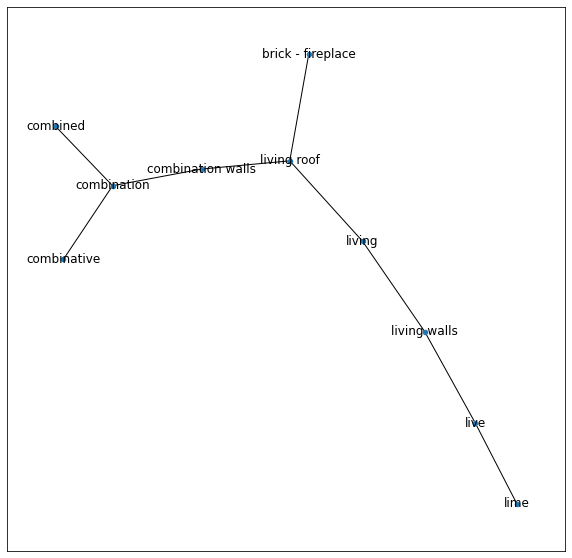

Community [2] of size 15, top 10 spans by degree:
0: drainage [43]
1: underground drainage [16]
2: underground storage tanks [13]
3: underground drains [13]
4: underground rainwater drainage [12]
5: rainwater pipes [11]
6: underground [10]
7: natural underground cavities [8]
8: underground utility vault [8]
9: basement storey [7]


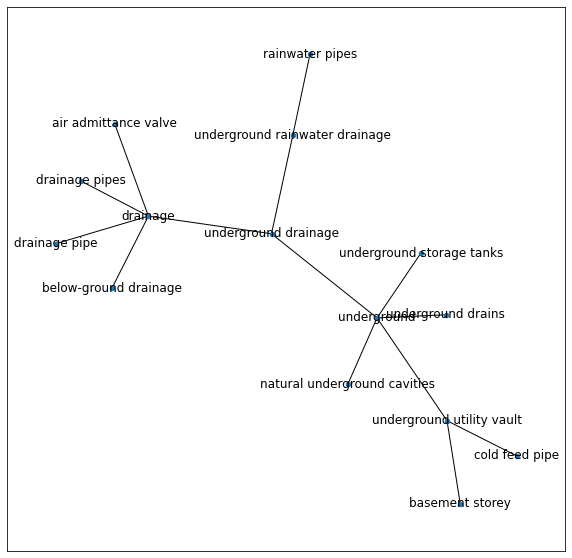

Community [3] of size 8, top 10 spans by degree:
0: sockets [8]
1: socket - outlets [7]
2: socket [7]
3: power socket [7]
4: socket outlets [6]
5: society [6]
6: Lockers [5]
7: Society [4]


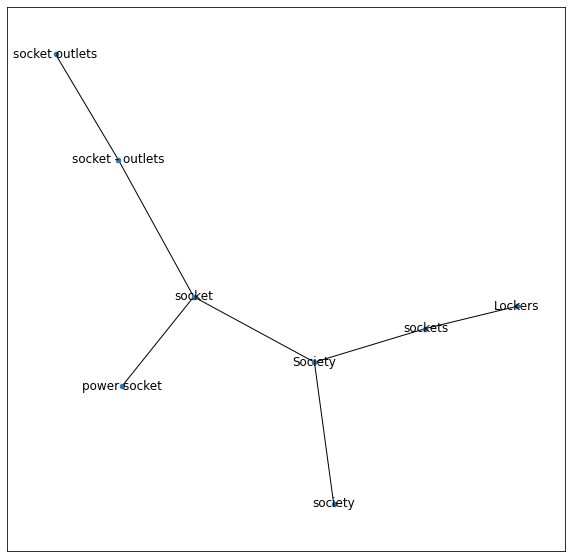

Community [4] of size 9, top 10 spans by degree:
0: stone [12]
1: natural stone tile [9]
2: natural stone [8]
3: Stone tiles [4]
4: artificial stone [2]
5: stove [2]
6: stone wool insulation [2]
7: stone material [2]
8: stone splinters [1]


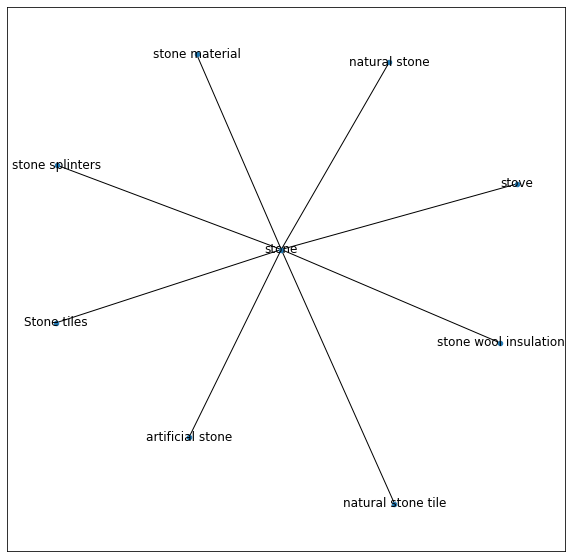

Community [5] of size 20, top 10 spans by degree:
0: pipes [48]
1: rainfall pipes [28]
2: shaft [27]
3: branches [23]
4: beam [23]
5: circulation [16]
6: branch pipes [15]
7: jacking pipes [12]
8: beams [11]
9: ring beam [11]


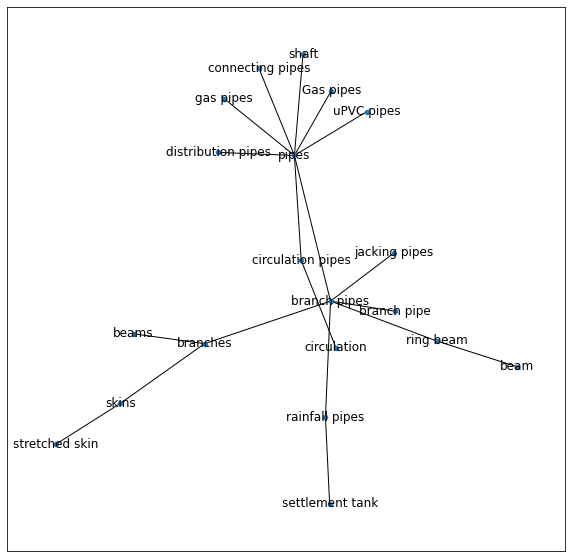

Community [6] of size 6, top 10 spans by degree:
0: mat wells [9]
1: lift wells [8]
2: well [7]
3: lift well [6]
4: Wells [5]
5: well - rounded rock fragments [5]


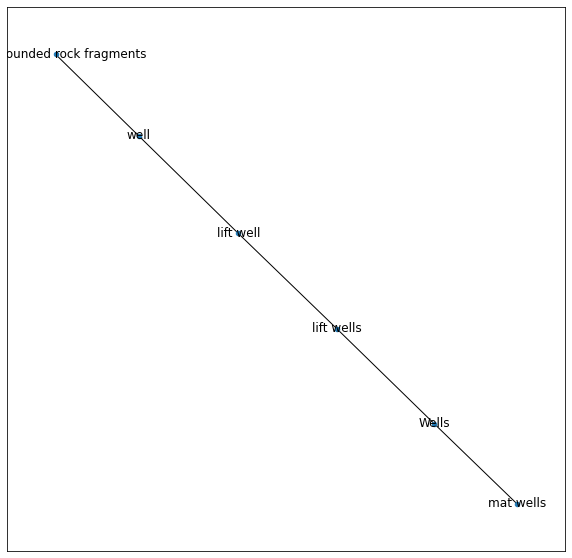

Community [7] of size 12, top 10 spans by degree:
0: band [19]
1: hand [16]
2: sand [12]
3: sediments [11]
4: limestone [8]
5: left - hand [7]
6: said [7]
7: travertine [4]
8: sane [3]
9: sad [2]


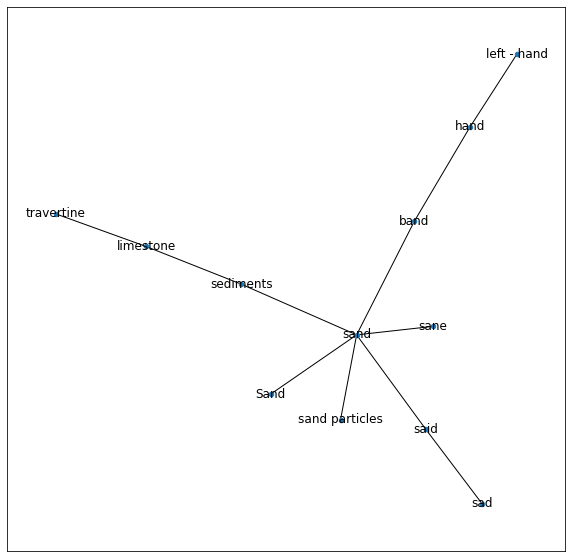

Community [8] of size 13, top 10 spans by degree:
0: values [34]
1: valleys [18]
2: gardens [16]
3: flashing [14]
4: callers [11]
5: lake [8]
6: straight valley [7]
7: pond [7]
8: pairs [5]
9: cap flashing [4]


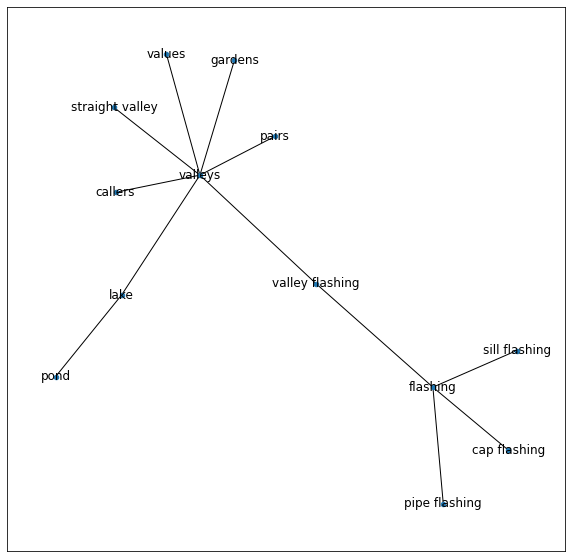

Community [9] of size 24, top 10 spans by degree:
0: bricks [35]
1: land [35]
2: soil [33]
3: soils [29]
4: soil gases [27]
5: organic [26]
6: vehicles [24]
7: cement [22]
8: mortar [21]
9: mortar material [21]


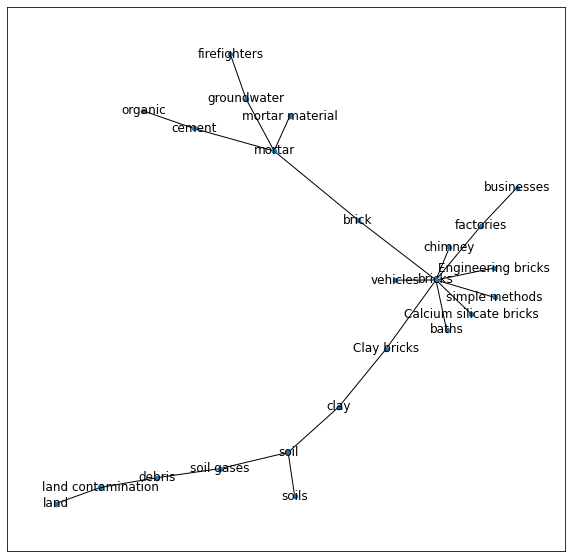

Community [10] of size 10, top 10 spans by degree:
0: fittings [39]
1: Signals [21]
2: skirting [12]
3: flanking [12]
4: fabrics [11]
5: shielding [11]
6: vesting [11]
7: stiffness [10]
8: Safety and [7]
9: skirtings [5]


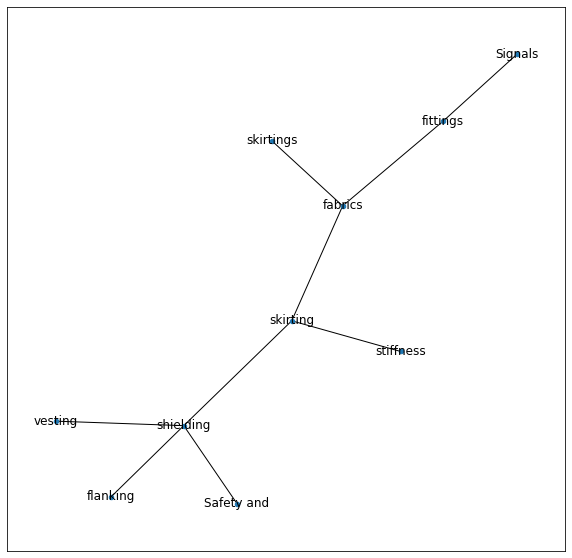

Community [13] of size 35, top 10 spans by degree:
0: section [57]
1: national [25]
2: column [20]
3: functional [17]
4: optional [16]
5: notional [16]
6: Inspection [16]
7: inspection [15]
8: Optional [15]
9: functions [15]


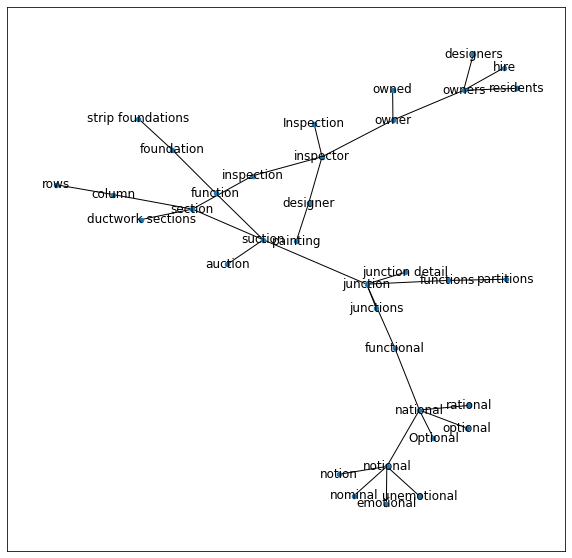

Community [0] of size 32, top 10 spans by degree:
0: directions [39]
1: differences [39]
2: boundary [32]
3: boundaries [31]
4: specimens [19]
5: classification boundary [14]
6: population [12]
7: curtilage plot boundary [11]
8: boundary relevant [9]
9: notional boundary [9]


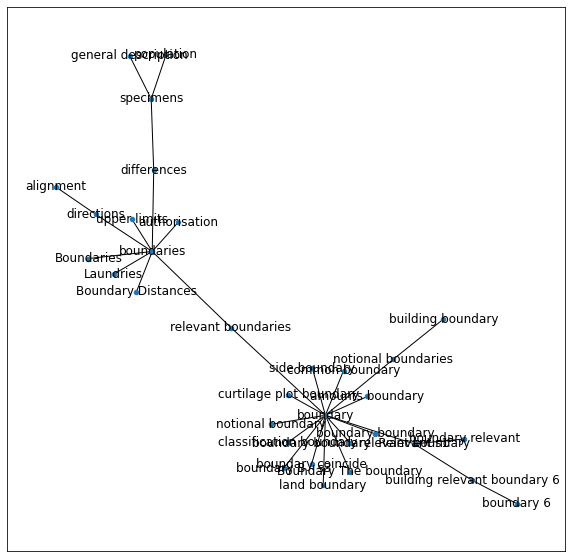

Community [1] of size 28, top 10 spans by degree:
0: area [171]
1: areas [110]
2: Area [90]
3: floor area [37]
4: accordance [36]
5: glazed area [24]
6: living areas [23]
7: area of [12]
8: sunken area [8]
9: total useful floor area [8]


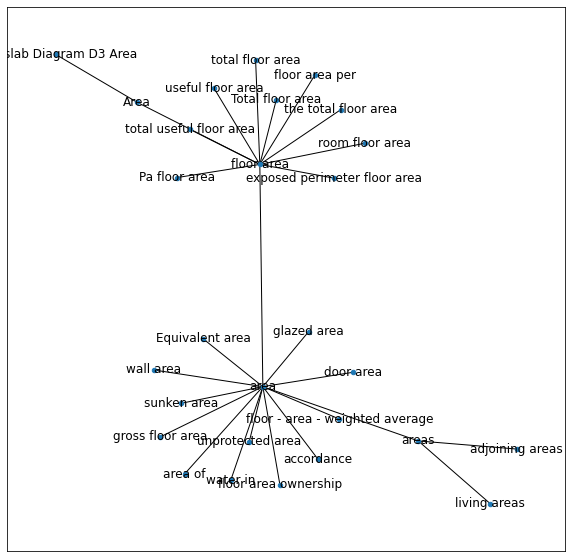

Community [2] of size 36, top 10 spans by degree:
0: dimension y Ceiling plan Materials [63]
1: Material change of use k [47]
2: Structural fire design BS EN 81 Safety rules [32]
3: Table D1 Floor space factors [27]
4: shrinkable clays [23]
5: Vicat softening temperature [22]
6: layouts [21]
7: Deposition [18]
8: buildings Flood resilient construction8 [14]
9: fire resistance Purpose group of building Mini [14]


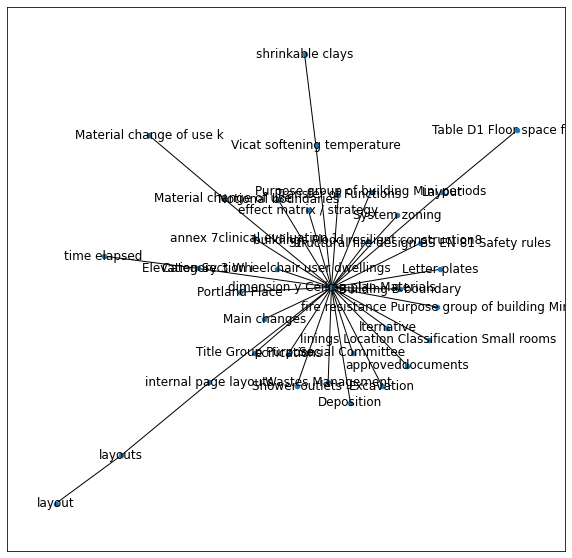

Community [3] of size 8, top 10 spans by degree:
0: BS 4514 Unplasticized PVC soil and ventilating pipes [55]
1: thermoplastics waste pipe BS 7157 Method of test [17]
2: BR 274 ) Fire Safety of PTFE - based Materials Used in Buildings [ 1994 [14]
3: External Thermal Insulation Walls of Multi - storey Buildings [13]
4: External [13]
5: Installation [12]
6: Materials [8]
7: buildingregulations [5]


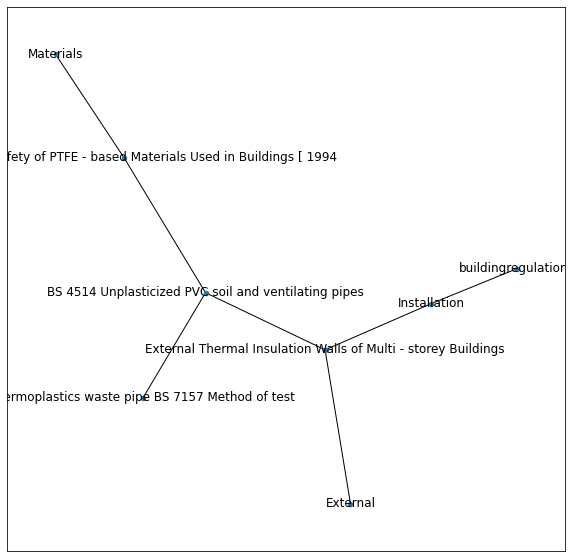

Community [4] of size 13, top 10 spans by degree:
0: free [17]
1: absorption area per [16]
2: absorption area A [14]
3: geometric free area [12]
4: Free area [11]
5: Free area Free area [10]
6: terms penetration [10]
7: Wall Fire - stopping [9]
8: free area [9]
9: aerodynamic free area [9]


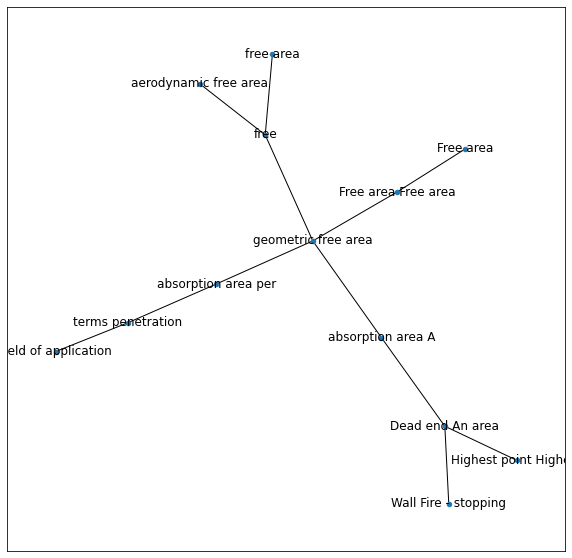

Community [5] of size 5, top 10 spans by degree:
0: For compartment walls [10]
1: For ramps [10]
2: For areas [8]
3: Therefore : Number [8]
4: For performance classifications standard [7]


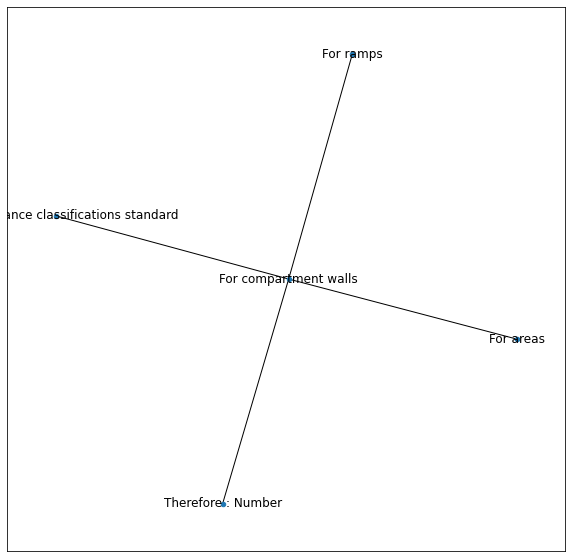

Community [6] of size 12, top 10 spans by degree:
0: hot water safety water efficiency Approved Document H Drainage [35]
1: Dimensions [20]
2: floor wall Dimensional restrictions [18]
3: Condensing boiler [10]
4: Dimensional [8]
5: Metric units [8]
6: plan dimensions [7]
7: Percentage [7]
8: dispersal [6]
9: vehicular [5]


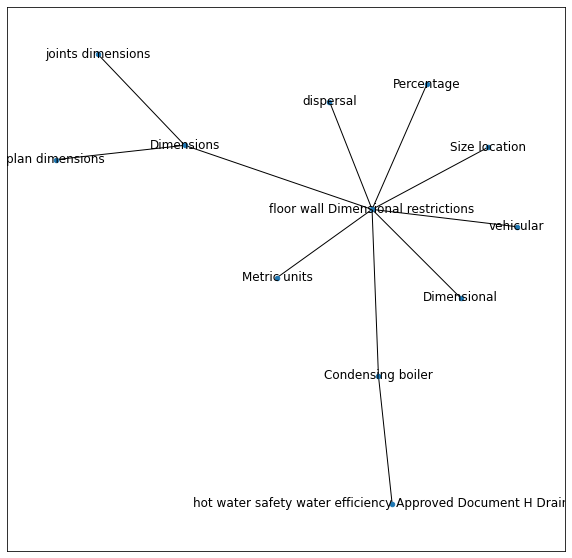

Community [7] of size 14, top 10 spans by degree:
0: distance [43]
1: boundary distance Space [18]
2: measure pointooflight face [15]
3: perimeter [13]
4: fanlights Unlim [12]
5: Space [12]
6: boundary distance Mini Space [12]
7: separation distances [9]
8: continuous space [9]
9: BS separation distances [7]


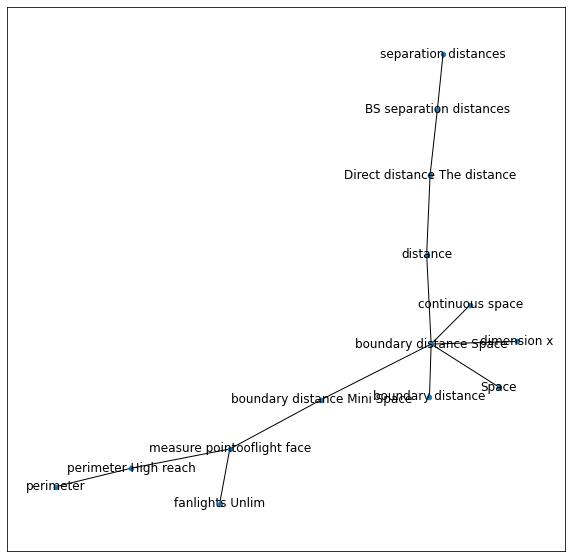

Community [0] of size 9, top 10 spans by degree:
0: glazed doors [21]
1: communal door [19]
2: external stair door [9]
3: patio doors [8]
4: either door Unlim [7]
5: external door [7]
6: single swing doors [6]
7: double door [6]
8: double doors [5]


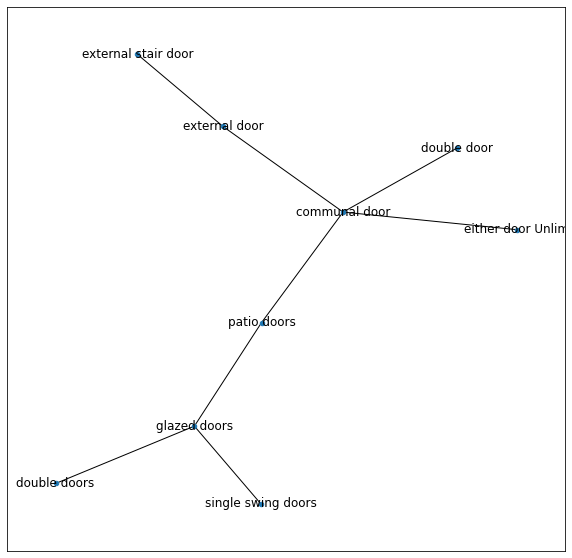

Community [1] of size 26, top 10 spans by degree:
0: door [136]
1: entrance [42]
2: BS EN 1634 - 1 Fire resistance test door and [33]
3: Point smoke BS EN 1634 - 3 Smoke control test door [21]
4: door Mini fire resistance [15]
5: BS 8214 Timber - based fire door assemblies [13]
6: fire door [13]
7: entrance door [12]
8: kind of door hardware [8]
9: door open [6]


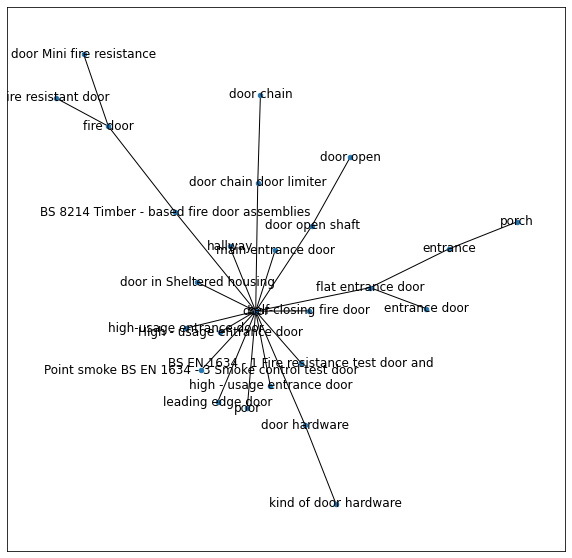

Community [2] of size 34, top 10 spans by degree:
0: doors [113]
1: Doors [99]
2: each door [15]
3: door stop [15]
4: revolving doors [14]
5: door EXAMPLE [11]
6: front [10]
7: door Mini [8]
8: door closing [7]
9: Trap doors [7]


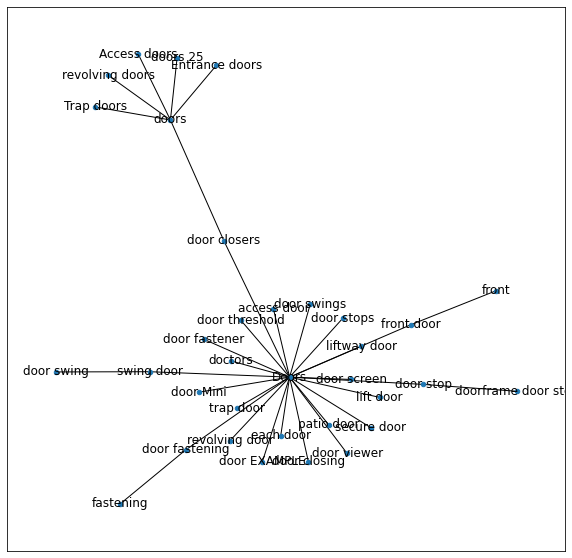

Community [3] of size 19, top 10 spans by degree:
0: doorway [38]
1: exit [37]
2: gates [22]
3: illuminated [19]
4: cracked [14]
5: outside [13]
6: seconds ii [13]
7: ladder [12]
8: ends [11]
9: Going [8]


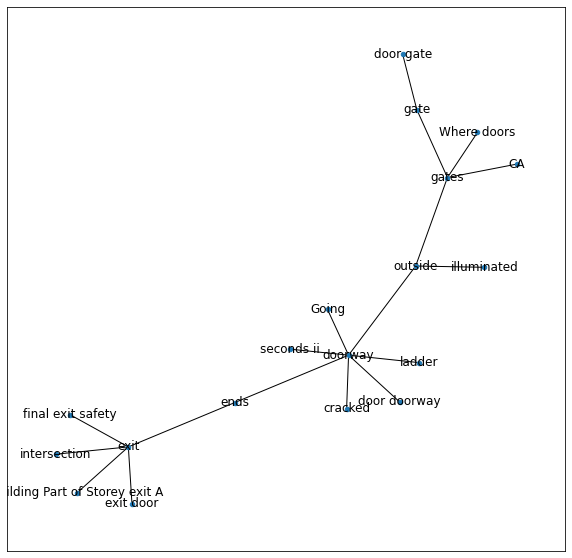

Community [4] of size 19, top 10 spans by degree:
0: fire doorsets door leaves [19]
1: fire doorset [19]
2: Fire door keep [18]
3: door furniture [17]
4: clear width door stop width [15]
5: doorset [15]
6: door leaf [12]
7: door opening furniture [12]
8: c d b inside edge door frame [12]
9: Fire door [10]


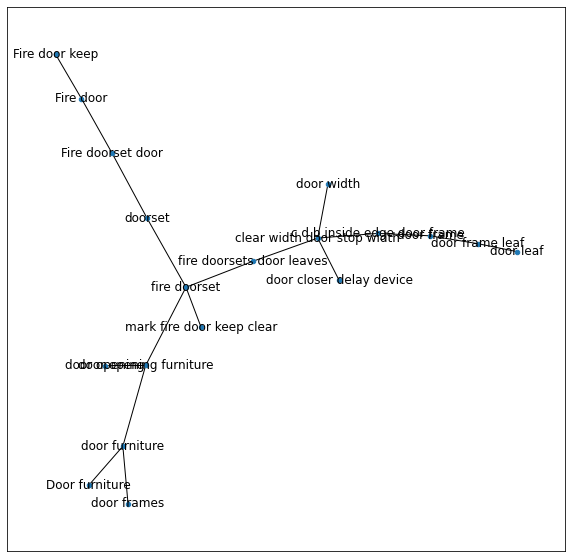

Community [5] of size 32, top 10 spans by degree:
0: internal doors [35]
1: lift doors [32]
2: automatic doors [24]
3: door assembly [22]
4: entrance doors [19]
5: landing doors [18]
6: swing doors [14]
7: release mechanisms doors [13]
8: progressive door [13]
9: hinges [12]


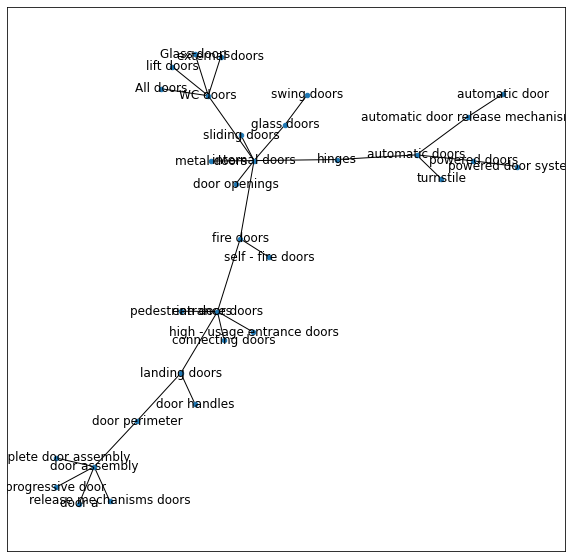

Community [0] of size 12, top 10 spans by degree:
0: regulation [94]
1: Building Regulations [29]
2: Buildings Regulations [18]
3: historic buildings [11]
4: historic [11]
5: Historic Buildings [10]
6: Historic [8]
7: Historic buildings [8]
8: Exempt Buildings [6]
9: building regulation requirements [5]


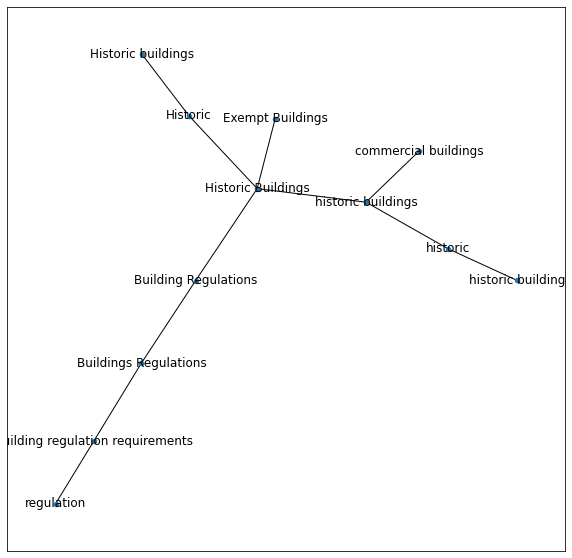

Community [1] of size 11, top 10 spans by degree:
0: body [24]
1: building control body [22]
2: building control bodies [14]
3: Building control body [14]
4: your local authority building control service [13]
5: bodies [11]
6: of building users [11]
7: building society work [10]
8: local authority building control [9]
9: local authority building control service [7]


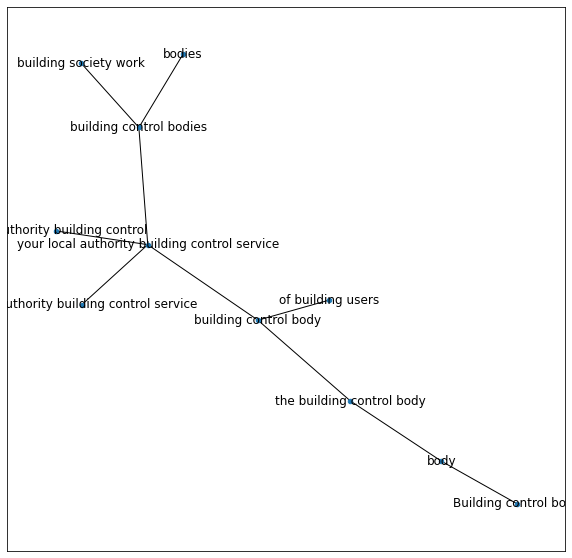

Community [2] of size 20, top 10 spans by degree:
0: common [39]
1: plant rooms surface [30]
2: swimming pool buildings [27]
3: assembly buildings [20]
4: heated common areas [20]
5: building types [15]
6: common building situations [13]
7: dance floor hall [11]
8: building users [11]
9: sports buildings [9]


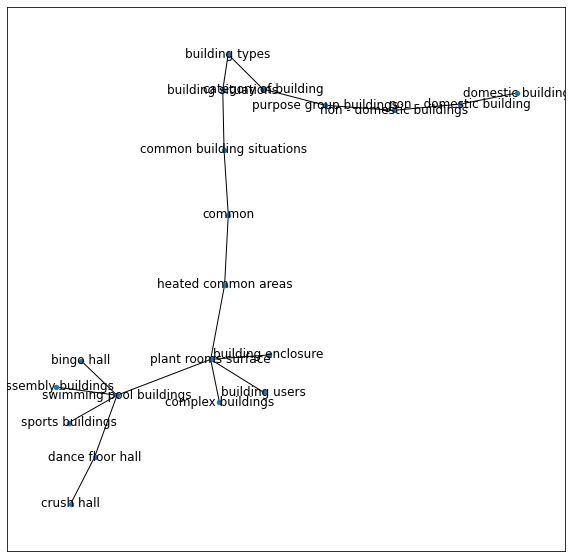

Community [0] of size 8, top 10 spans by degree:
0: building in [12]
1: residential building [10]
2: residential building in Dornach [9]
3: residential building in [7]
4: residential building in Zofingen [7]
5: residential building in Herisau [5]
6: building in Zofingen [4]
7: building in Witley [2]


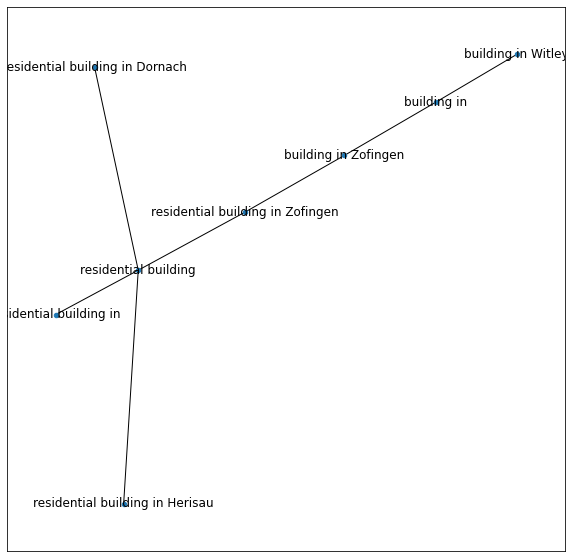

Community [1] of size 4, top 10 spans by degree:
0: building components [14]
1: in - building physical infrastructure [11]
2: speed - ready in - building physical infrastructure [8]
3: In - building physical infrastructure [5]


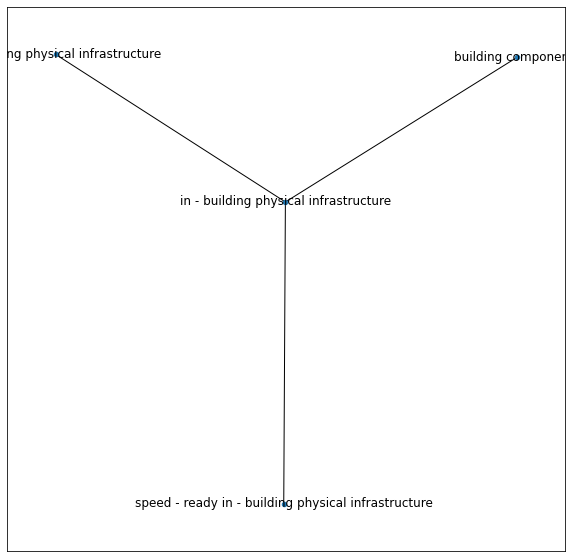

Community [2] of size 11, top 10 spans by degree:
0: building service installations fire resisting BS 476 Fire tests [25]
1: building services [18]
2: building service installations [15]
3: fixed building services [11]
4: fixed building service [11]
5: energy - efficient fixed building services [10]
6: fixed building [8]
7: fixed building services i [7]
8: Fixed building services [7]
9: building services ducts [7]


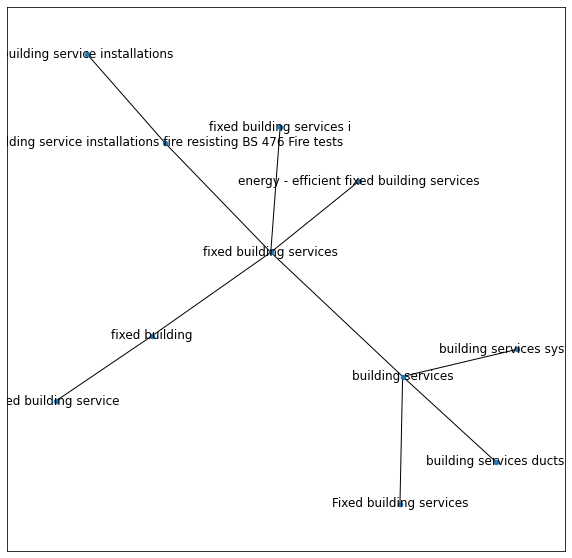

Community [3] of size 3, top 10 spans by degree:
0: commercial [19]
1: commercial building [6]
2: residential and commercial building [5]


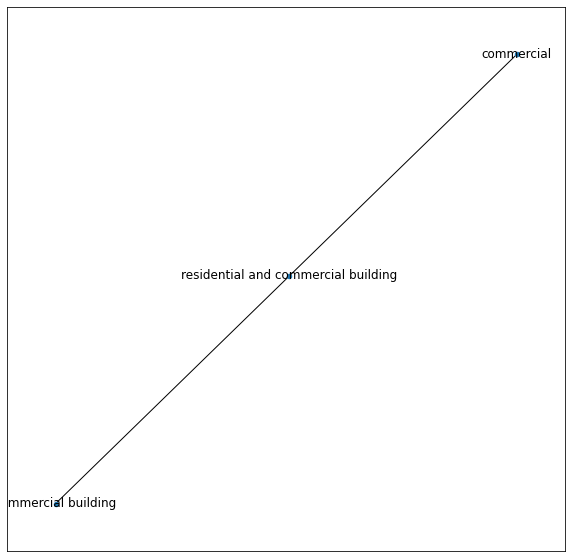

Community [4] of size 25, top 10 spans by degree:
0: building [164]
1: silicon [13]
2: building access point [11]
3: building Minimum [9]
4: building Minimum Alternative minimum provisions [8]
5: building elements [8]
6: individual building fabric elements [8]
7: sculpture [8]
8: institutional building [6]
9: composite building material [6]


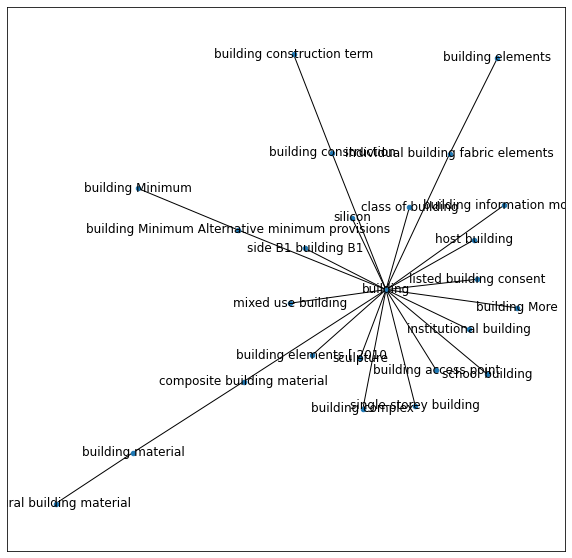

Community [0] of size 3, top 10 spans by degree:
0: building fabric [11]
1: building envelope’ [10]
2: building envelope [10]


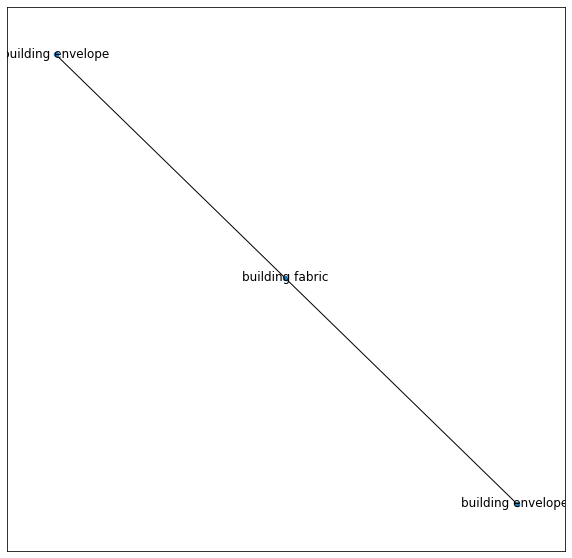

Community [1] of size 6, top 10 spans by degree:
0: portable buildings [16]
1: residential buildings [9]
2: traditional buildings [9]
3: temporary building [6]
4: public buildings [6]
5: school buildings [5]


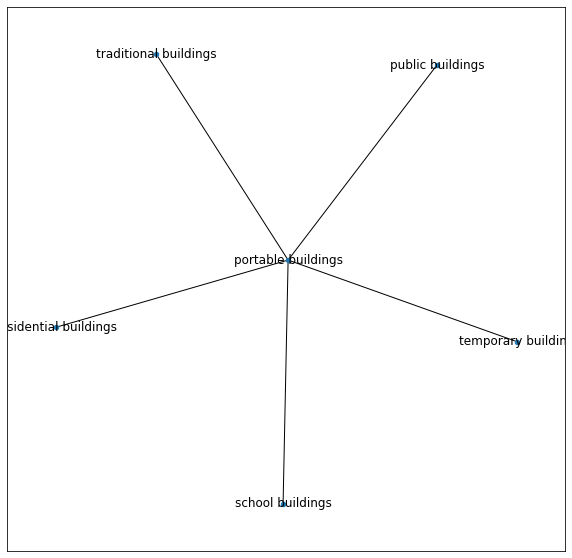

Community [2] of size 40, top 10 spans by degree:
0: buildings [145]
1: Buildings [133]
2: building b [11]
3: buildings BS 8414 [10]
4: Council Directive 95 / 16 / Buildings [8]
5: public building [8]
6: Building B1 [8]
7: building walls [7]
8: building wall [6]
9: protected building [6]


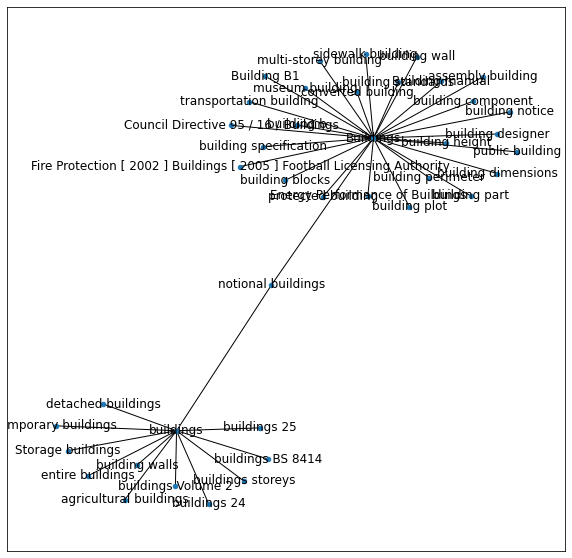

Community [3] of size 10, top 10 spans by degree:
0: BUILDING [16]
1: NEW BUILDINGS [11]
2: building basement [10]
3: Building Approved [9]
4: building societies [7]
5: BUILDING OR [7]
6: outbuildings [7]
7: outbuilding [6]
8: build - up [6]
9: building basement separated [3]


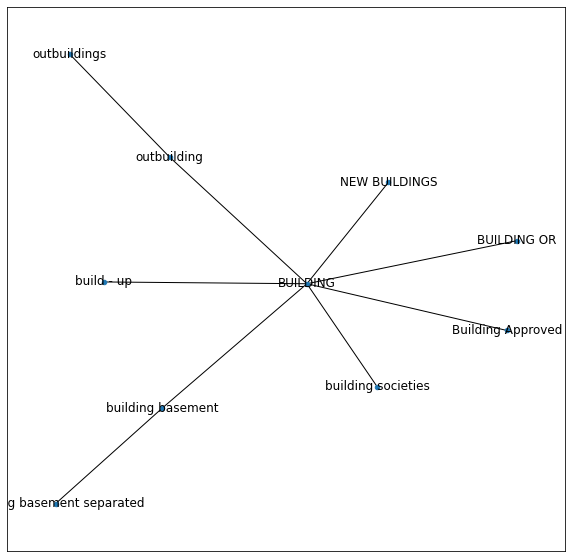

Community [4] of size 5, top 10 spans by degree:
0: building occupants [16]
1: buildings amount [11]
2: building owner [8]
3: building element [6]
4: buildings Introduction [5]


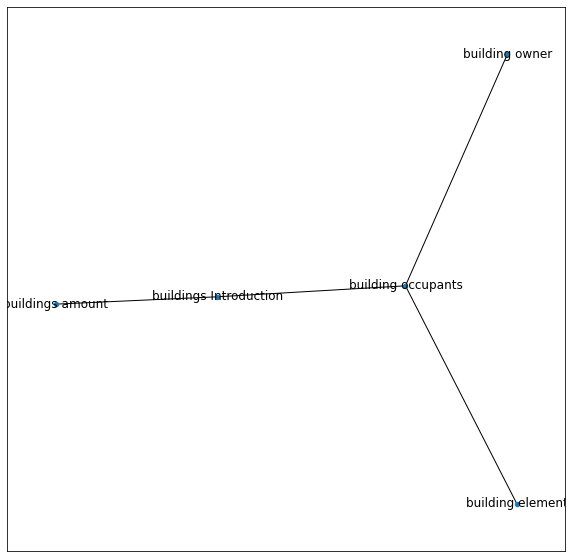

Community [5] of size 25, top 10 spans by degree:
0: single [36]
1: single storey buildings [22]
2: storey building [17]
3: single - storey non - residential buildings [14]
4: top storey building [12]
5: small buildings [11]
6: low - rise buildings [11]
7: building storey [10]
8: residential accommodation ceiling [10]
9: small single stair buildings [9]


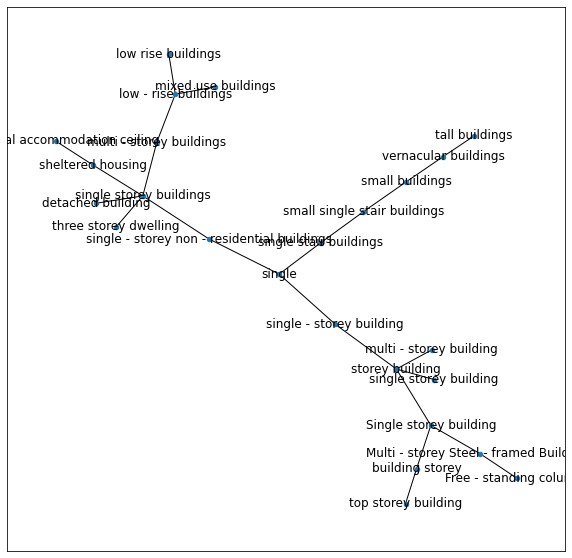

Community [6] of size 6, top 10 spans by degree:
0: Listed Buildings Conservation Areas [9]
1: Grade II listed building [8]
2: Listed Buildings [8]
3: Ancient Buildings [8]
4: listed buildings [6]
5: grade II listed building [3]


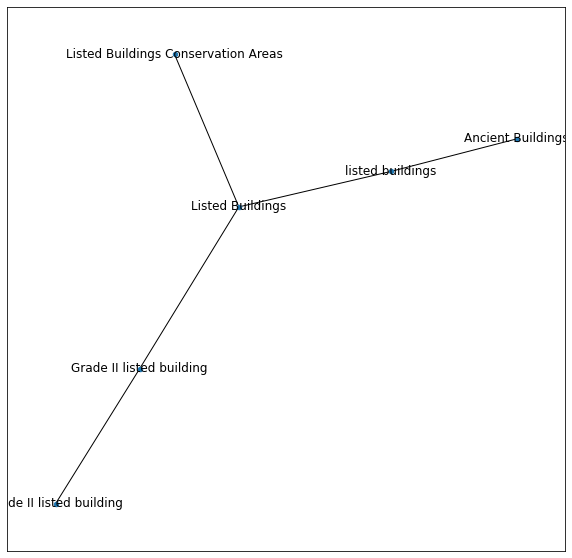

Community [7] of size 8, top 10 spans by degree:
0: performance [52]
1: in mathematics [20]
2: common notions [17]
3: BS EN ISO 13370 Thermal performance of buildings [13]
4: athl [11]
5: BS EN ISO 13370 Thermal performance of buildings Heat transfer [10]
6: surface artistic [7]
7: residential quarters [7]


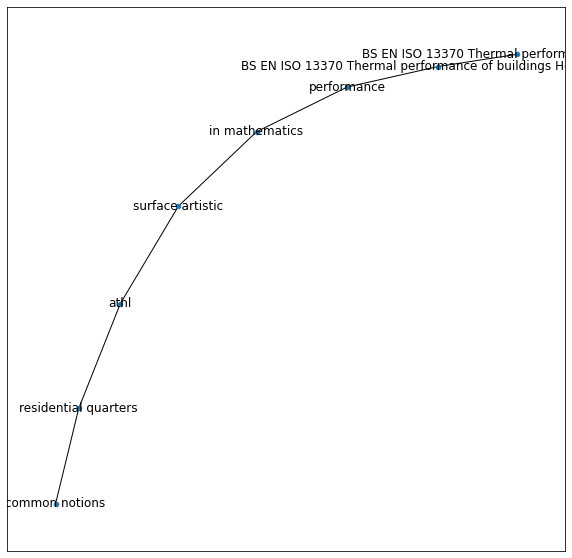

Community [8] of size 13, top 10 spans by degree:
0: work [37]
1: Building work [15]
2: new building work [15]
3: Most building work [14]
4: notional building [12]
5: building work [11]
6: building works [8]
7: edial work [7]
8: new building [7]
9: new buildings [7]


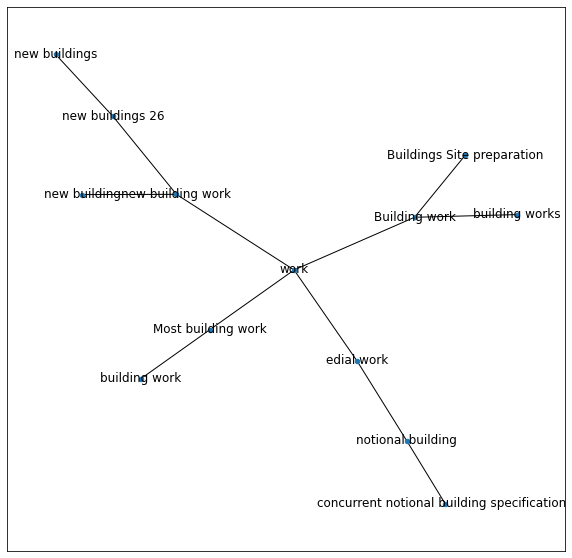

Community [9] of size 23, top 10 spans by degree:
0: materials [43]
1: office [29]
2: building sites [23]
3: building materials [15]
4: Buildings office [14]
5: building gallery [12]
6: site investigation [11]
7: site [11]
8: commissioning notice [8]
9: For buildings [7]


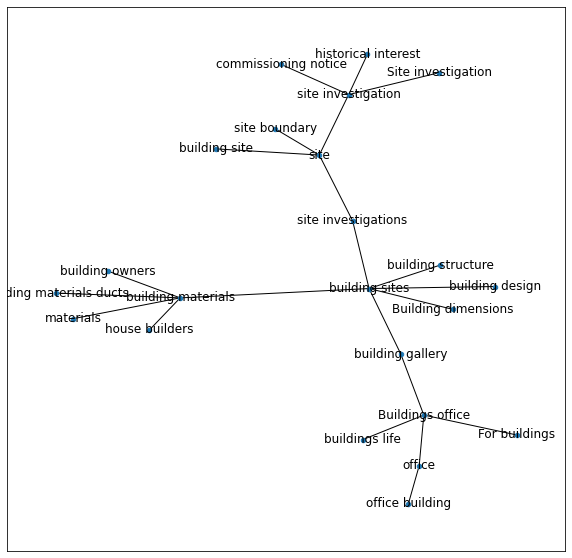

Community [0] of size 7, top 10 spans by degree:
0: partition [10]
1: stud [8]
2: concealed space [5]
3: stud wall [5]
4: stud wall partition [5]
5: privacy [3]
6: dividing partition [1]


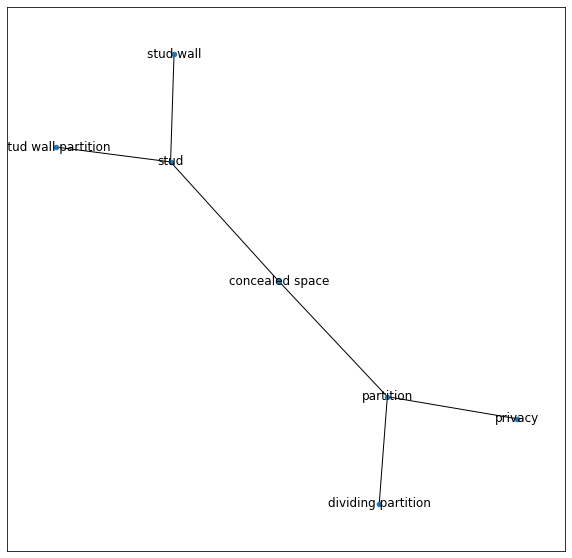

Community [1] of size 16, top 10 spans by degree:
0: solid [48]
1: solids [25]
2: solid fuel / gas / oil / all [12]
3: thick [12]
4: thickness [12]
5: Any assumptions [9]
6: Every wall [8]
7: All assumptions [8]
8: all [8]
9: wall thickness [8]


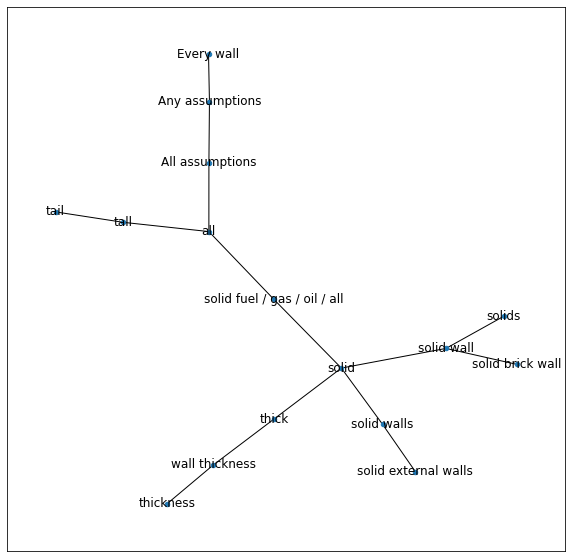

Community [0] of size 5, top 10 spans by degree:
0: Separating [32]
1: separating wall [12]
2: separating wall joint [3]
3: type 4 separating wall [3]
4: separating walls [3]


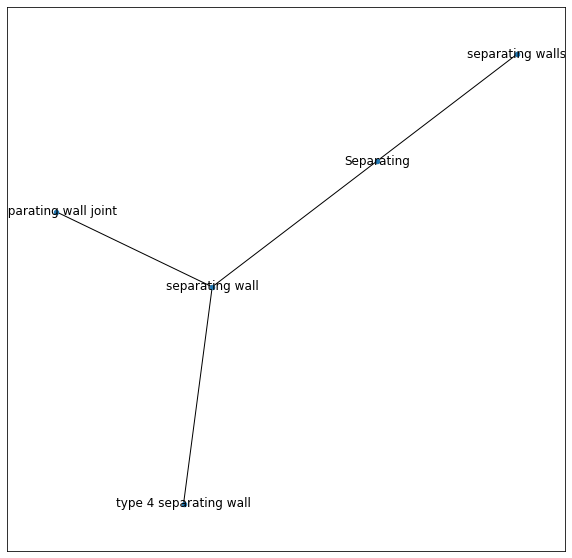

Community [1] of size 21, top 10 spans by degree:
0: walls [165]
1: wall [160]
2: inner wall leaves [6]
3: inner wall [6]
4: existing wall [5]
5: wall leaves [5]
6: boundary wall [5]
7: wall surface [5]
8: slab wall [4]
9: front wall [4]


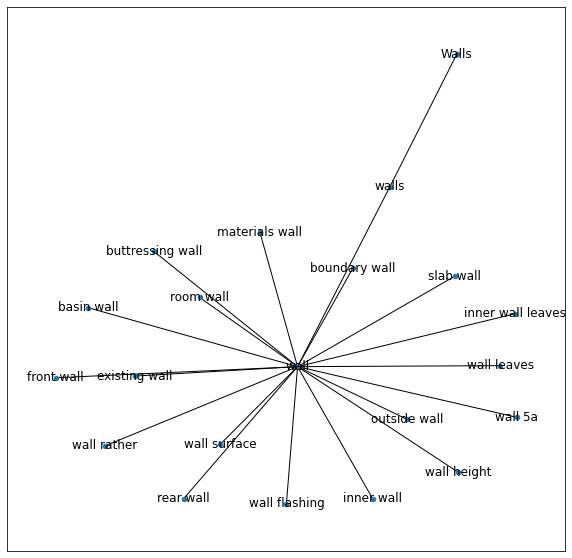

Community [2] of size 3, top 10 spans by degree:
0: finish [9]
1: wall finish [5]
2: wall finish leaf [4]


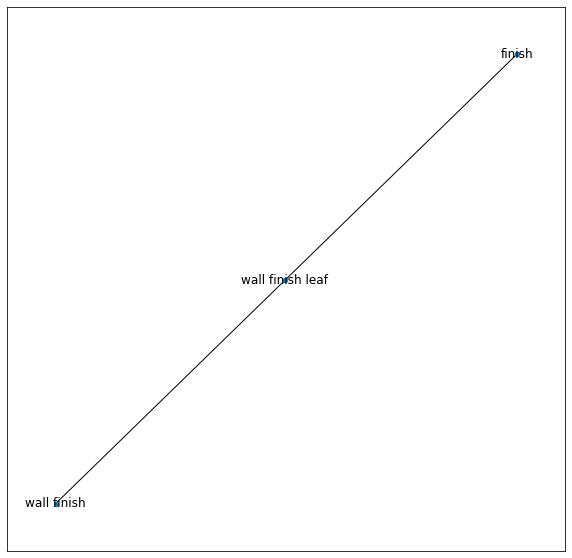

Community [3] of size 2, top 10 spans by degree:
0: shared [9]
1: shared wall [4]


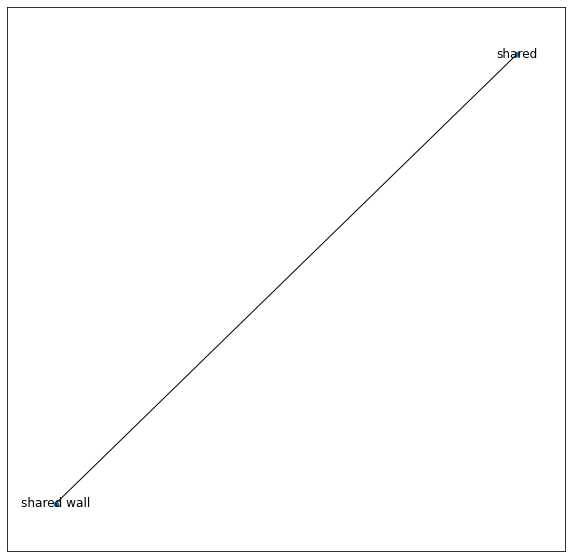

Community [4] of size 14, top 10 spans by degree:
0: Wall ceiling linings Classification [33]
1: volume [22]
2: Wall [20]
3: wall coverings [19]
4: wall in [15]
5: Wall types [9]
6: layout walls [8]
7: gable wall [8]
8: Wall Wall [7]
9: volume walls [6]


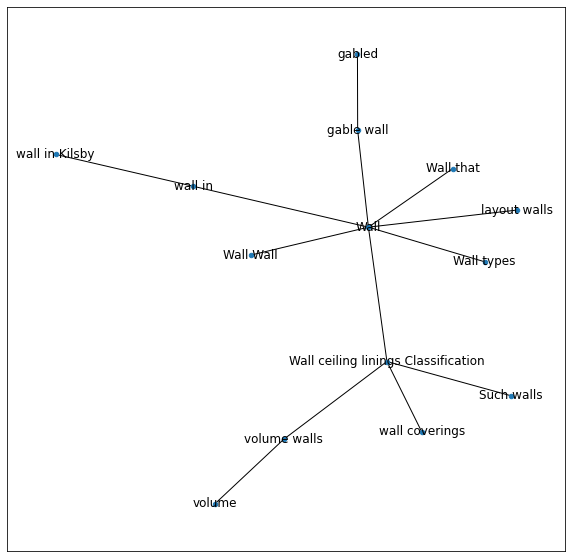

Community [5] of size 2, top 10 spans by degree:
0: returnable [8]
1: return wall [6]


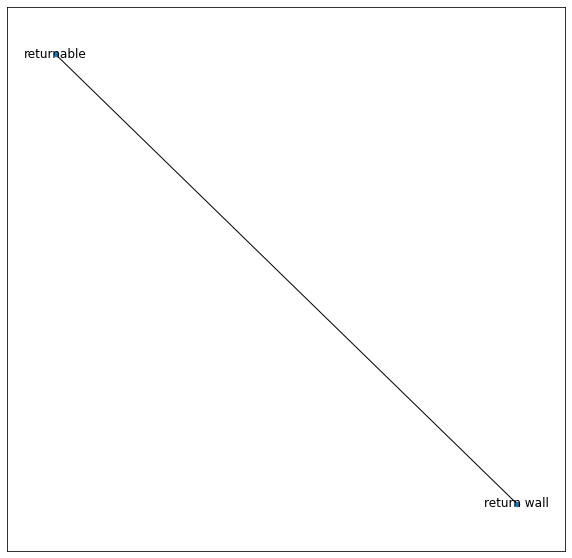

Community [6] of size 4, top 10 spans by degree:
0: framed wall [12]
1: party wall [8]
2: moeity [1]
3: fibreboard [1]


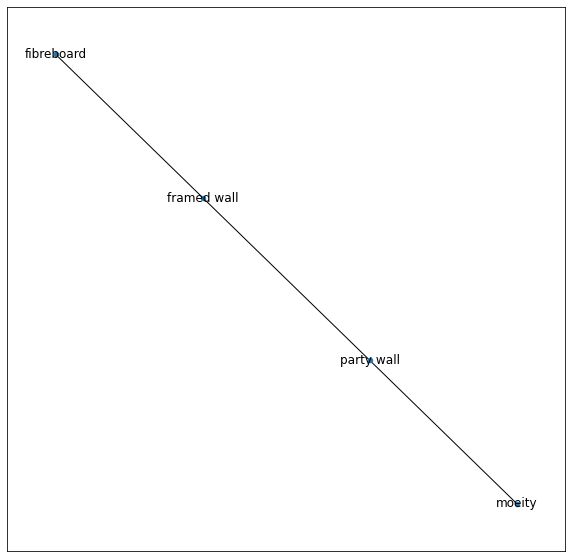

Community [7] of size 14, top 10 spans by degree:
0: walled [122]
1: wall lining [23]
2: wall partition [9]
3: wall common [7]
4: common wall [5]
5: walls partitions [4]
6: wall of [4]
7: exemption walls [3]
8: construction walls [3]
9: base walls [3]


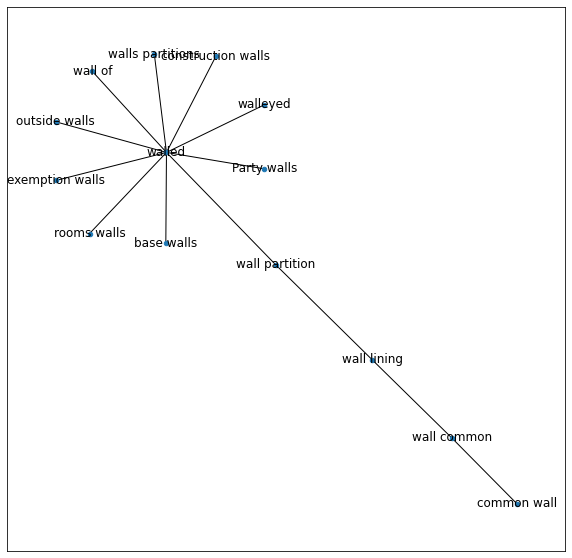

Community [8] of size 2, top 10 spans by degree:
0: wall R [5]
1: R [5]


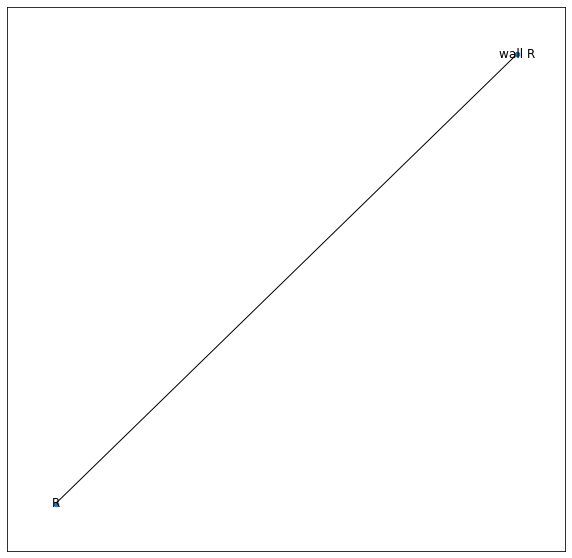

Community [9] of size 4, top 10 spans by degree:
0: loadbearing [10]
1: loadbearing element [7]
2: loadbearing wall [6]
3: loadbearing walls [3]


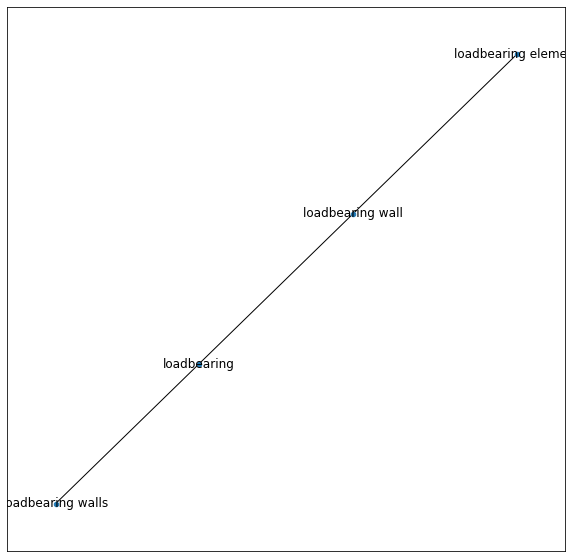

Community [3] of size 15, top 10 spans by degree:
0: part [43]
1: parts [39]
2: weather [13]
3: weather - resisting part [13]
4: openings wall [11]
5: Storey part [9]
6: parts wall [8]
7: wind - driven rain [8]
8: wall parts [7]
9: break - out [6]


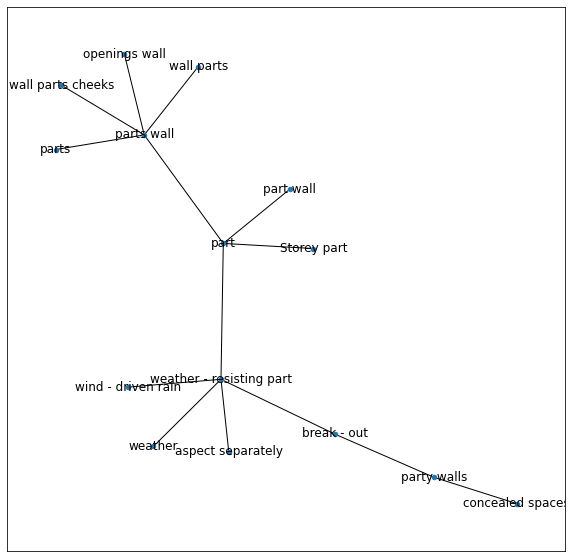

Community [4] of size 22, top 10 spans by degree:
0: external [62]
1: external wall [18]
2: external cavity walls [17]
3: external walls The external envelope [15]
4: Approved Document K [15]
5: external cavity wall [13]
6: external walls [10]
7: secondary containment [8]
8: external fire spread [7]
9: External surface materials [7]


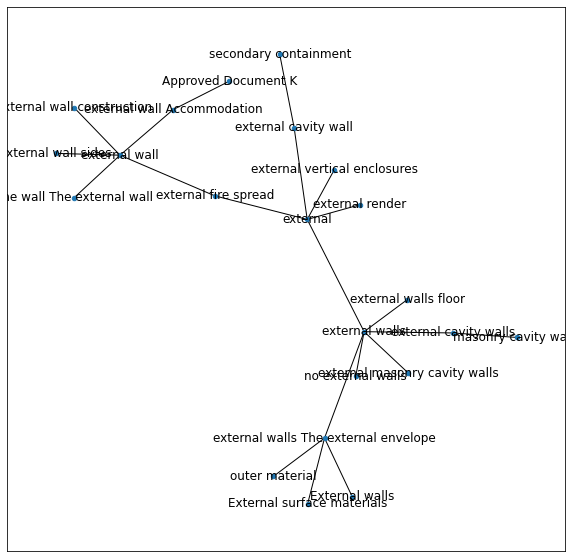

Community [5] of size 13, top 10 spans by degree:
0: internal [57]
1: internally [36]
2: international [32]
3: Internal walls [12]
4: Internal linings [10]
5: internal wall [10]
6: internal walls [10]
7: Internal doors [9]
8: Internal planning [8]
9: internal diameter [7]


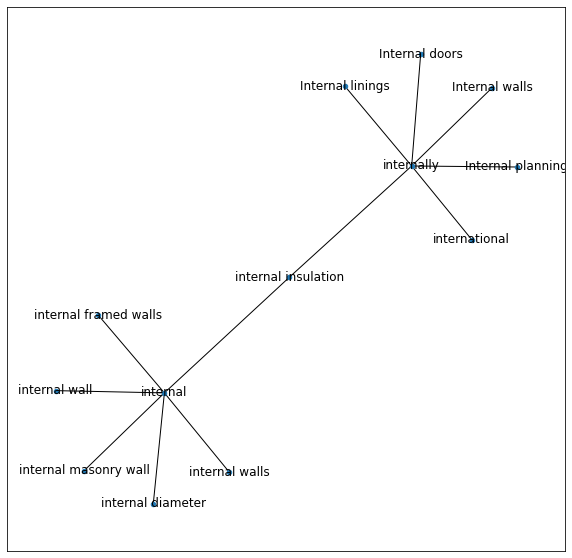

Community [6] of size 13, top 10 spans by degree:
0: wall ties [13]
1: rigid connection [12]
2: Wall ties [11]
3: tension straps [11]
4: sealed joints [10]
5: tension - membrane roofs [8]
6: horizontal ties [8]
7: wall tie [7]
8: Cavity [7]
9: tied [7]


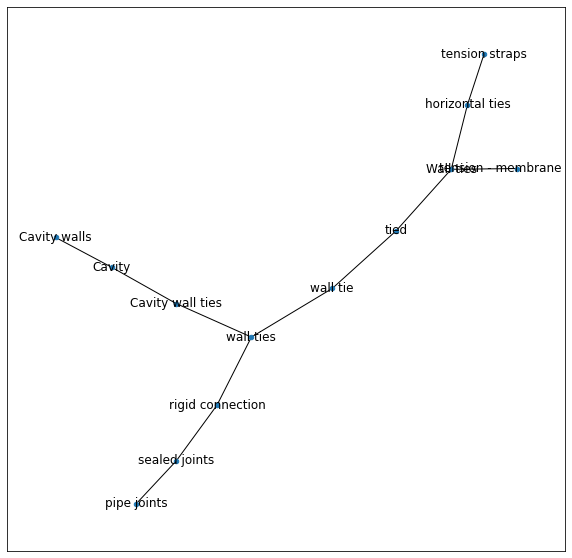

Community [7] of size 3, top 10 spans by degree:
0: Surrounding [12]
1: surroundings [7]
2: surrounding walls [5]


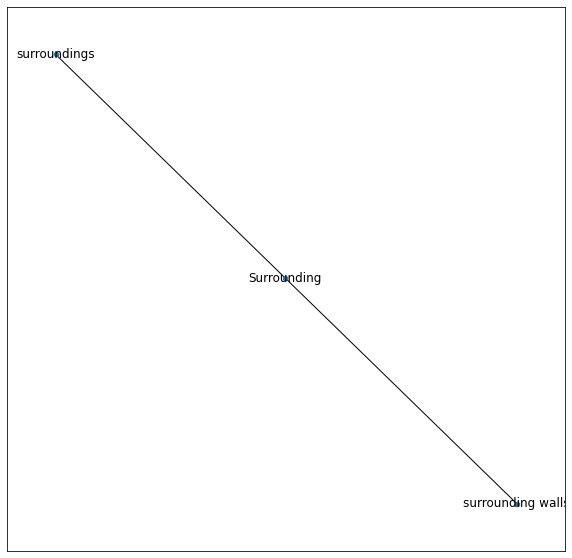

Community [8] of size 20, top 10 spans by degree:
0: side [59]
1: sides [40]
2: cavity barriers [16]
3: cavity walls [14]
4: side walls [11]
5: green walls [9]
6: exposure side [9]
7: side wall [8]
8: accommodation side [7]
9: green c [7]


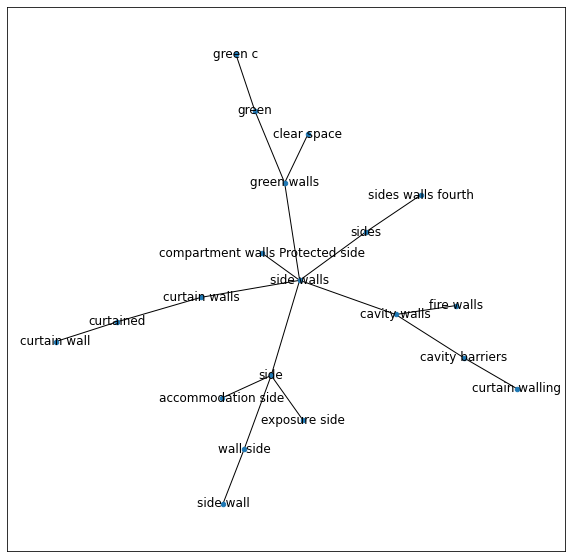

Community [9] of size 28, top 10 spans by degree:
0: cavity [69]
1: masonry [30]
2: cavity width [17]
3: cavity wall [16]
4: solid masonry [13]
5: near - roof part of [13]
6: masonry cross - wall construction [13]
7: cavity wall construction [12]
8: masonry wall [11]
9: masonry cavity wall construction [11]


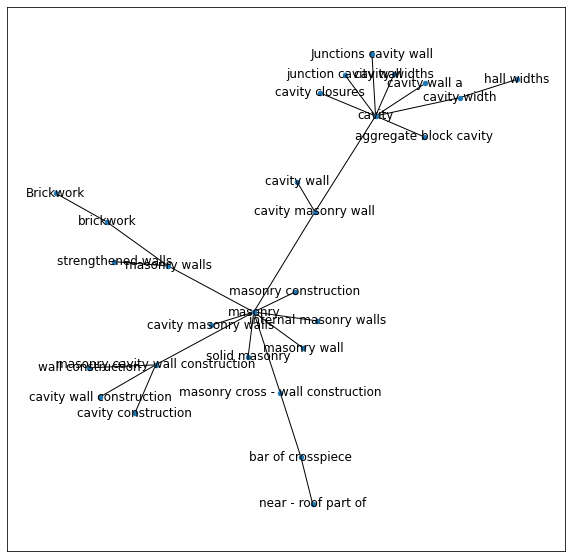

Community [0] of size 10, top 10 spans by degree:
0: sheeting [29]
1: sheet [25]
2: sheets [18]
3: envelope [18]
4: fully supported lead sheet roof [14]
5: sheet roof [10]
6: roof sheeting [9]
7: occupants [8]
8: sleeving [7]
9: external envelope [3]


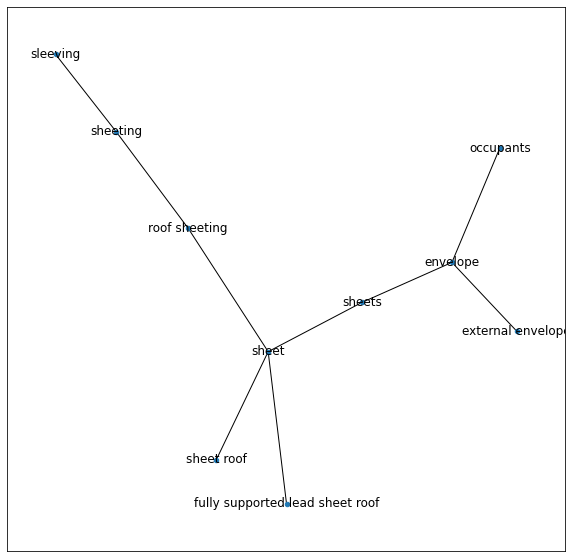

Community [1] of size 22, top 10 spans by degree:
0: roof [111]
1: slope [29]
2: impact sound pressure level [21]
3: sloping plots [15]
4: Mean ground walls level Lowest c [14]
5: roof point [14]
6: ground walls Highest roof slope [13]
7: Mean roof level point [11]
8: roof slope roof [10]
9: Intermediate values [9]


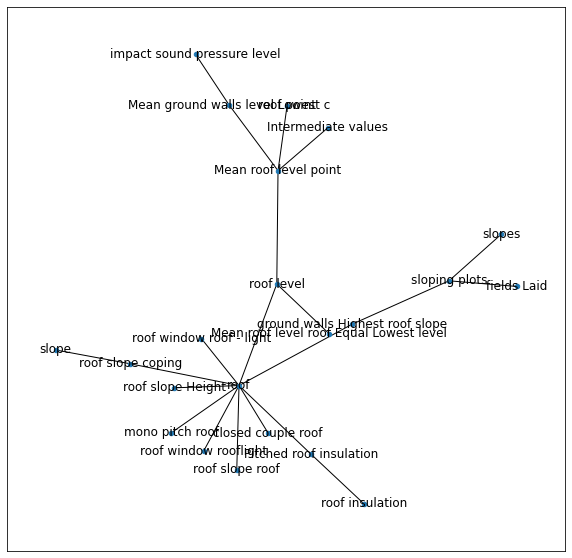

Community [2] of size 15, top 10 spans by degree:
0: plastic [44]
1: plastic rooflights [23]
2: sheet roof wall coverings [22]
3: Roof sheeting outer point [19]
4: plastic rooflights rooflights [13]
5: lintel [12]
6: mould growth [12]
7: Plastic rooflights [11]
8: timber tiling battens [11]
9: wood shingles [9]


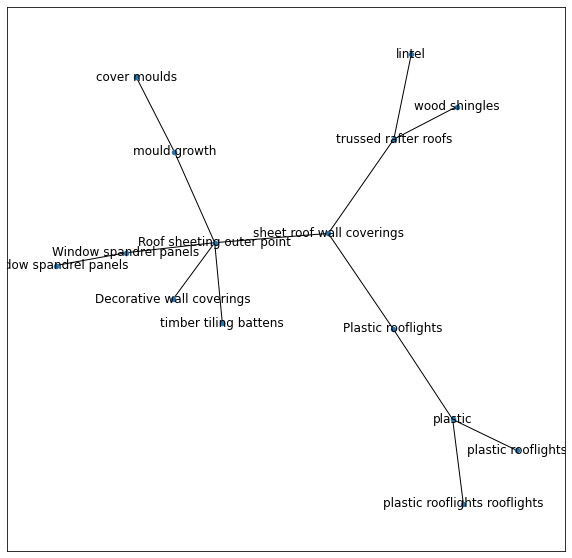

Community [3] of size 7, top 10 spans by degree:
0: roof - top plant areas storey [26]
1: roof - top plant areas Height [19]
2: fit - out work [14]
3: roof slope building [8]
4: performance wall lining [8]
5: worktop side [7]
6: chamfered [6]


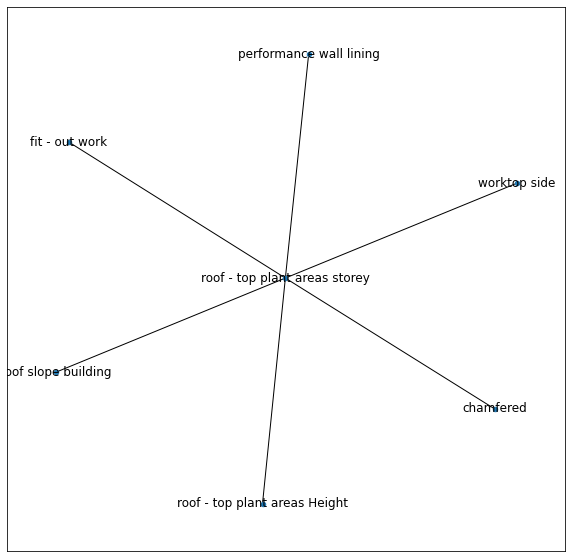

Community [4] of size 16, top 10 spans by degree:
0: roofing [80]
1: roofed [78]
2: roofs [16]
3: roof coverings [15]
4: Roof floor cavity The ceiling [15]
5: Roof covering [14]
6: Roof constructions [14]
7: Signals : Safety performance - of - green - roofs - and - walls [14]
8: roof covering [13]
9: roof Distance [11]


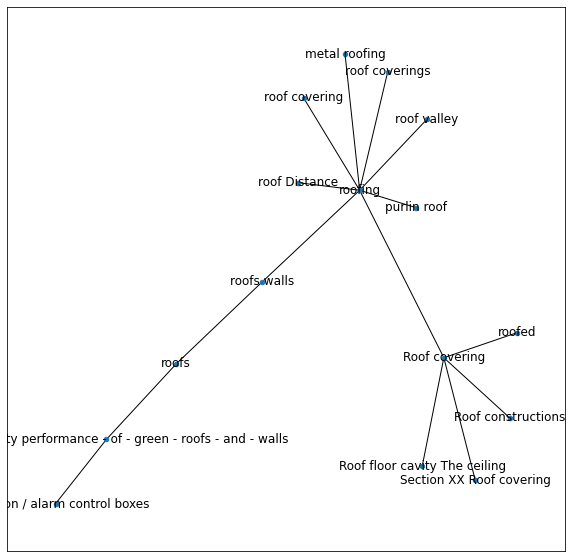

Community [19] of size 48, top 10 spans by degree:
0: type [68]
1: panel [43]
2: type of [37]
3: panels [35]
4: independent panels Junctions wall type 3 1 [34]
5: Type of [29]
6: types [24]
7: dwellings [22]
8: separating wall type 3 2 [20]
9: plastic panels [19]


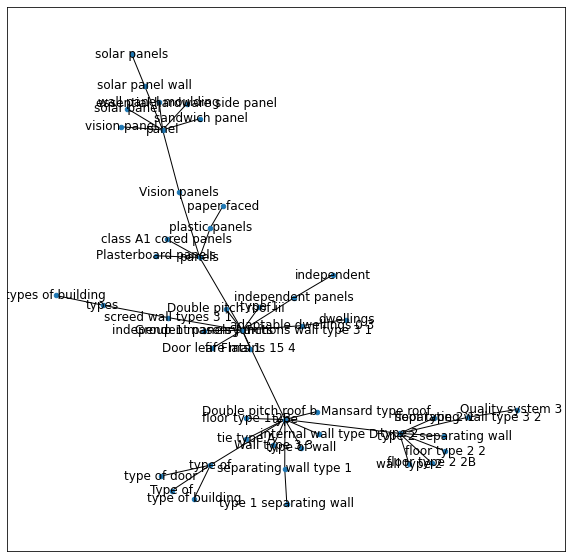

Community [0] of size 25, top 10 spans by degree:
0: fire [273]
1: construction [56]
2: fire tests [35]
3: fire resisting [35]
4: fire resisting separation floor [30]
5: Non - fire resisting construction Accommodation Accommodation Configuration A Configuration B protection [18]
6: fire - resistant power and control cable systems life safety [16]
7: fire resisting construction wall [14]
8: fire resisting construction [11]
9: fire resisting ductwork Ductwork [10]


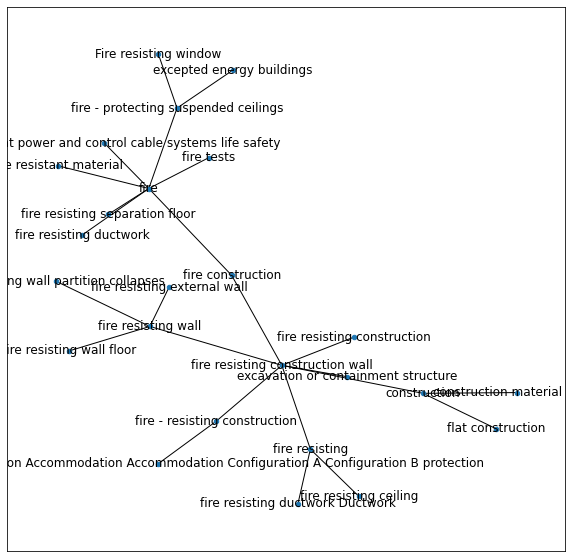

Community [1] of size 8, top 10 spans by degree:
0: protected stairway [56]
1: stairway [19]
2: fire stairway b ) resistance [15]
3: fire A gallery [9]
4: newel post [8]
5: meters stairway [6]
6: protected stairway firefighting building [6]
7: parapet [4]


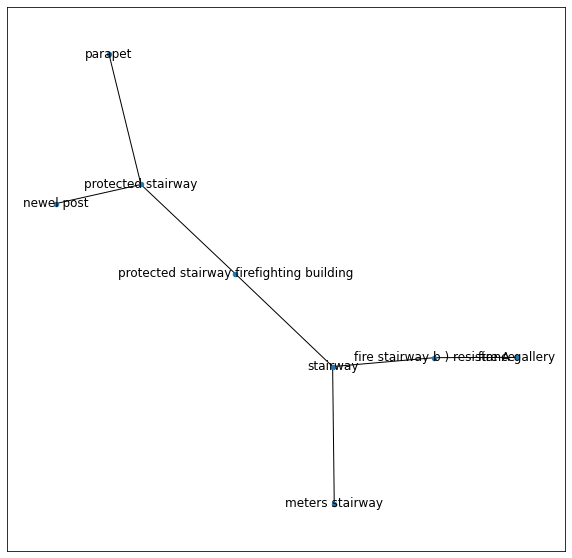

Community [2] of size 14, top 10 spans by degree:
0: resistance [57]
1: fire resistance [48]
2: firefighting shafts Volume 2 Buildings B1 2 46 Residential care homes sprinkler systems B1 3 21 Width of evacuation B1 5 46 Shop store rooms B3 7 7 Raised Table 8 1 Maximum building [44]
3: Resisting [24]
4: resistible [18]
5: heat exhaust doors fire resistance test [ 2018 ] ventilators [ 2017 [17]
6: fire resistance insulation criterion Relevant boundary Amount [16]
7: fire resistance portal frames B4 13 22 Methods area sprinkler systems B5 17 8 Location [15]
8: fire resistance portal frames B4 11 21 Methods area sprinkler systems B5 15 7 Provision [15]
9: Sa fire doors Mini fire resistance REI 60 [14]


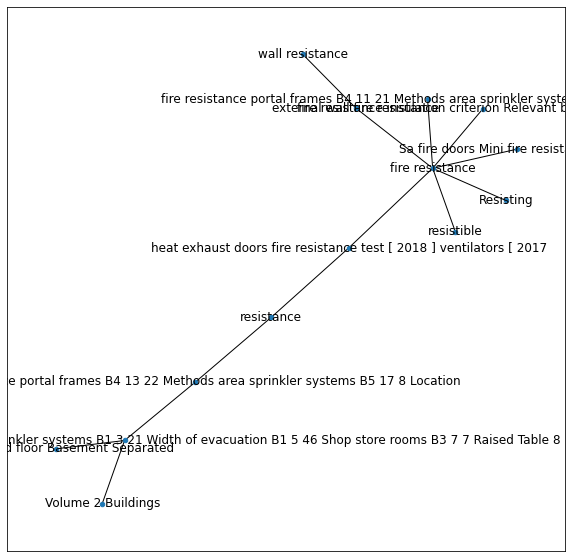

Community [3] of size 13, top 10 spans by degree:
0: ducts [58]
1: store rooms [30]
2: ES damper SD SD Ductwork Ductwork Fd Fire doorset serving area serving area Fd NOTE : Ventilation ducts [26]
3: doorways [24]
4: Ventilation [23]
5: WITH LOBBY Protected Protected shaft shaft Corridor Lobby Glazed Glazed screen screen Fire resistance [16]
6: walls stairway Protected lobby Ductwork serving area Fd Fire doorset Ductwork serving area Fd NOTE : Ventilation ducts [9]
7: Ventilation ducts [9]
8: bin storage [8]
9: mantle shelves [6]


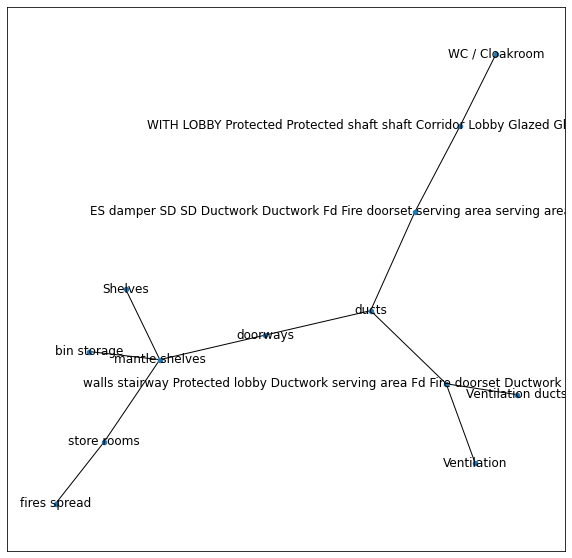

Community [4] of size 14, top 10 spans by degree:
0: RATED [40]
1: NOTE [16]
2: min NOTES [15]
3: wall NOTES [14]
4: provisions NOTES [13]
5: diffuser NOTES [12]
6: dwellings NOTE [9]
7: NOTES [8]
8: NOTES : 1 [8]
9: NOTE 2 : Double doors [7]


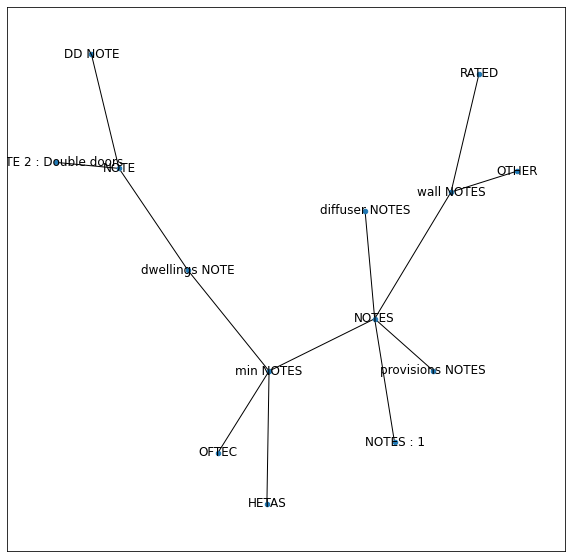

Community [5] of size 10, top 10 spans by degree:
0: mm zone m fire resisting side of stair 6m maximum [31]
1: Shop sales area  7 0 11 [11]
2: shower 700mm [8]
3: one storey 90m2 [8]
4: Wall 200mm [8]
5: mm 1000mm [8]
6: snooker room hall 10 0 14 [8]
7: 100mm zone bathroom [7]
8: rise 474 shallower 1 : 19 e [6]
9: mm bathroom [4]


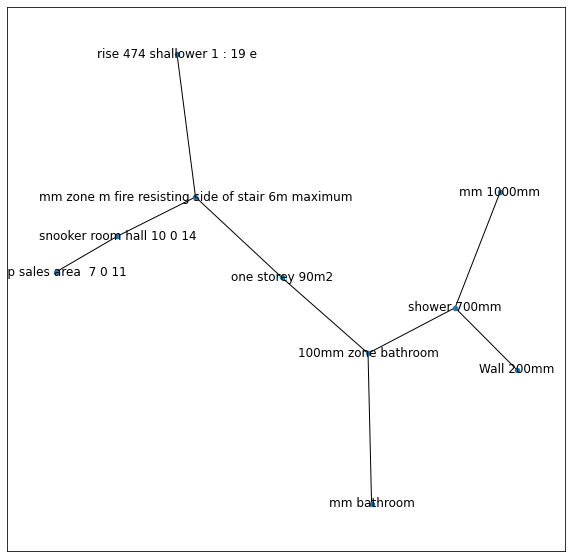

Community [6] of size 13, top 10 spans by degree:
0: ducting [27]
1: ductwork [18]
2: pipework [10]
3: ductwork systems [6]
4: ductwork serving [6]
5: polyvinyl chloride [5]
6: low - pressure ductwork [4]
7: ductwork system [4]
8: ductwork leakage testing [3]
9: Flexible ductwork [3]


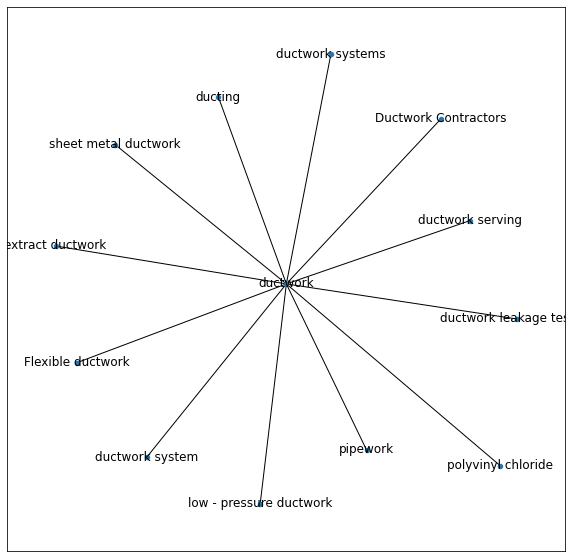

In [20]:
### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# I think Louvain results in something else each time
max_path_steps = 3
nodes = set(nx.single_source_shortest_path_length(network, "party wall", cutoff=max_path_steps).keys())
subgraph = network.subgraph(nodes)
divide_into_communities(subgraph)

Community [0] of size 5, top 10 spans by degree:
0: ceramic material [28]
1: black material [13]
2: magnetic material [9]
3: construction material [8]
4: construction material made [5]


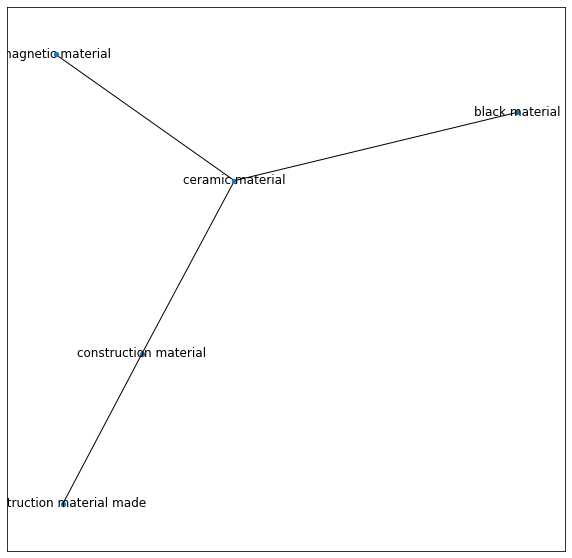

Community [1] of size 2, top 10 spans by degree:
0: Thermoplastic materials B11 Thermoplastic material [10]
1: Thermoplastic material [2]


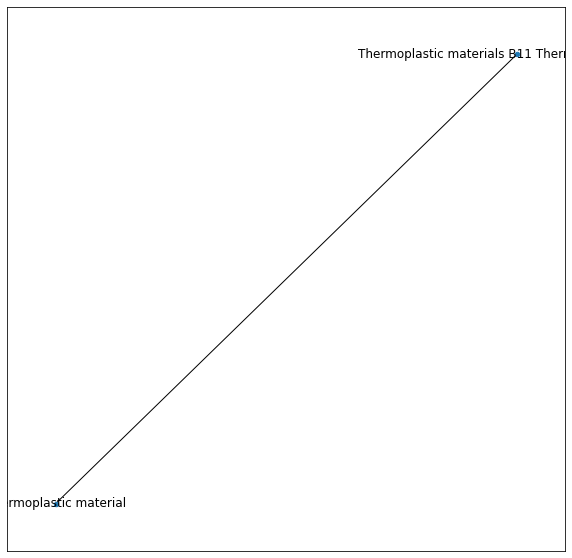

Community [2] of size 4, top 10 spans by degree:
0: material change of [14]
1: material change [13]
2: material change of use [12]
3: material alteration [6]


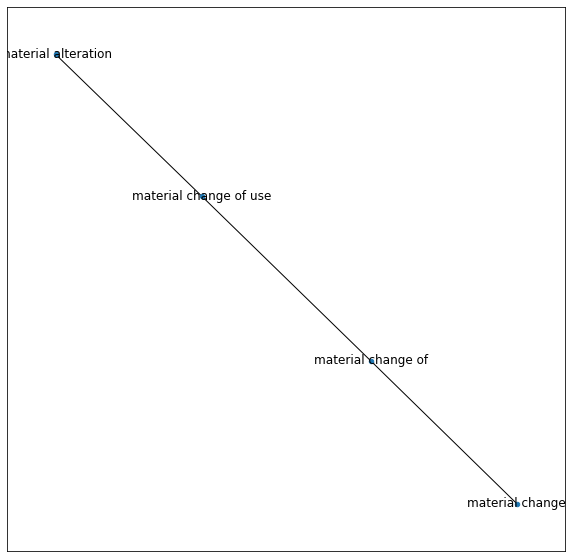

Community [3] of size 36, top 10 spans by degree:
0: material [69]
1: elements [43]
2: lining [37]
3: accordance [36]
4: equipment [28]
5: substrate [19]
6: material opsi gov uk / click - use / system / online / pLogin asp [12]
7: Factory - made chimneys material [11]
8: thermoplastic material [11]
9: material s3 [10]


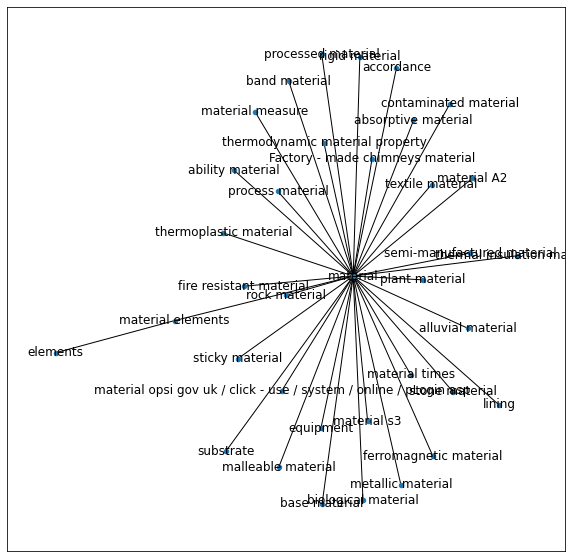

Community [4] of size 2, top 10 spans by degree:
0: maternal [11]
1: paternal [7]


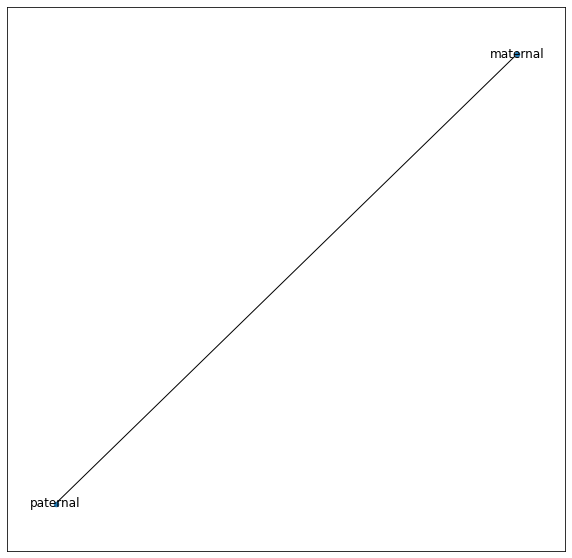

Community [5] of size 5, top 10 spans by degree:
0: insulating material [20]
1: resilient material [12]
2: combustible material [9]
3: absorbent material [8]
4: with absorbent material [6]


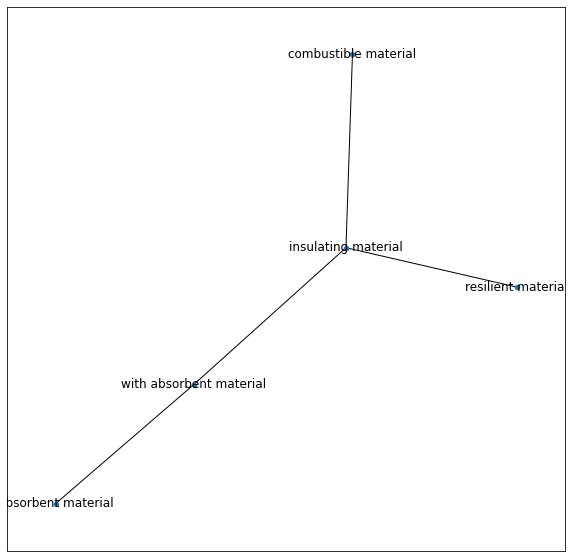

Community [6] of size 11, top 10 spans by degree:
0: porous material [13]
1: granular material [11]
2: fibrous material [10]
3: any laminated material [8]
4: composite construction material [7]
5: composite building material [6]
6: building material [6]
7: natural building material [5]
8: composite material [5]
9: natural material [3]


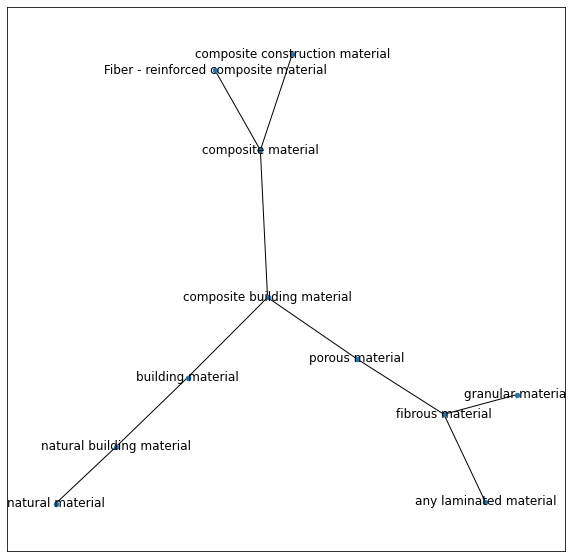

Community [7] of size 2, top 10 spans by degree:
0: flexible material [16]
1: outer material [7]


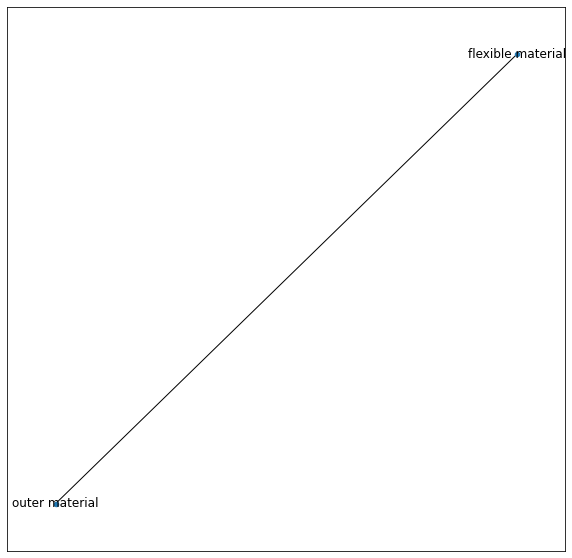

Community [8] of size 3, top 10 spans by degree:
0: mortar material [21]
1: solid material [20]
2: filler material [6]


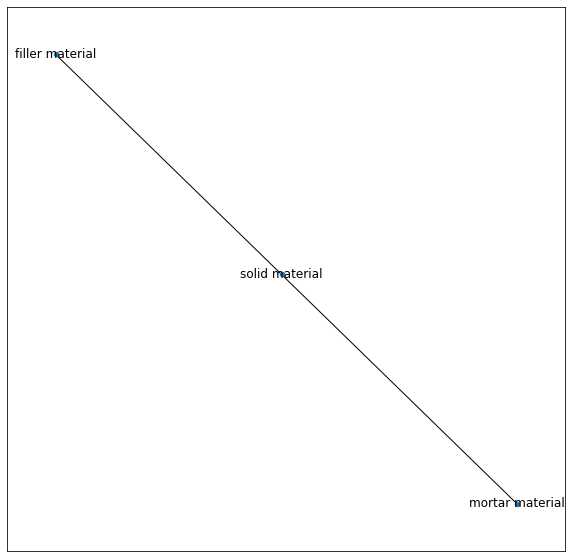

In [21]:
### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# different result each time
max_path_weight = 1 * maximum_distance
nodes = set(nx.single_source_dijkstra_path(network, "material", cutoff=max_path_weight).keys())
subgraph = network.subgraph(nodes)
divide_into_communities(subgraph)


In [ ]:
# L = nx.laplacian_matrix(G)

### SPARQL identification of directly related spans

In [43]:
# Single term query 
user_query = 'party wall'
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>

SELECT ?other_label
WHERE {
    ?a irec:related|^irec:related|^irec:definitionRelation|irec:definitionRelation|irec:constitutes|^irec:constitutes ?b . 
    ?b rdfs:label ?other_label .
    ?a rdfs:label ?value .
    FILTER (CONTAINS(LCASE(str(?value)), "QUERY"))
}
""".replace('QUERY', user_query)

In [44]:
res = irec_graph.query(test_query)    

In [47]:
len([(Literal(user_query, lang='en'), r.other_label) for r in res if r.other_label != Literal(user_query)])

16

In [48]:
# trying to direclty create the graph from the sparql result
start = time()
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from([(Literal(user_query, lang='en'), r.other_label, {'weight': 1}) for r in res if r.other_label != Literal(user_query)])
print(f"took {time()-start} seconds")

took 0.0004999637603759766 seconds


In [49]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
start = time()
edge_list = []
weight_list = []
for row in res:
    if Literal(user_query) != row.other_label:
        edge_list.append((Literal(user_query), row.other_label, {"weight": 1}))
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from(edge_list)
print(f"took {time()-start} seconds")

took 0.0006792545318603516 seconds


In [50]:
print(f"Number of edges related to `{user_query}`: {len(edge_list)}")

Number of edges related to `party wall`: 16


In [51]:
span_degree_dict = dict(UG.degree((g for g in impact_graph.nodes())))
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

Top 20 spans by degree:
1: residence [3]
2: notional boundary [2]
3: framed wall [2]
4: adjoining dwelling [1]
5: building owner [1]
6: moeity [1]
7: buildings [1]
8: dividing partition [1]
9: tenants [1]
10: units [1]
11: walls [1]


In [80]:
test_graph = nx.Graph()
for t in edge_list:
    test_graph.add_edge(t[0], t[1])

In [ ]:
mst = nx.minimum_spanning_tree(test_graph)

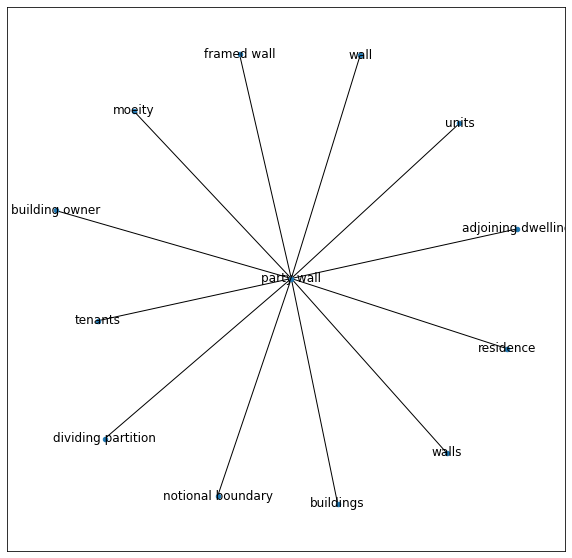

In [83]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(mst, with_labels=True, node_size = 20)
plt.show()

### SPARQL identification of terms meeting minimum requirements
* span has a wikidata definition 
* if span contains an antonym, is there a morphologically similar span with the antonym
* wikiclass
* domain-classification 


In [84]:
# All constitutes relations
test_query = """
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select ?span ?definition ?related ?related_node_def  where { 
	# grab the span of interest
	?s rdfs:label ?span .
    FILTER (LCASE(str(?span))="party wall"||LCASE(str(?span))="party walls")
    # grab definition, if the node has one
    OPTIONAL{
        ?s irec:exactMatch/skos:definition|irec:wikiDefinition ?definition .
    }
    # grab any related objects
    OPTIONAL{
        ?s irec:related|^irec:related|irec:definitionRelation|^irec:definitionRelation ?o .
        ?o rdfs:label ?related .
        # grab definition, if the node has one
        OPTIONAL{
            ?o irec:exactMatch/skos:definition|irec:wikiDefinition ?related_node_def .
        }
        }
} limit 100 

"""
res = irec_graph.query(test_query)

In [85]:
for row in res:
    print(row)

(rdflib.term.Literal('Party walls', lang='en'), None, None, None)
(rdflib.term.Literal('party walls', lang='en'), None, None, None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('adjoining dwelling', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('building owner', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('moeity', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units

### All relations of a type

In [17]:
for row in res:
    print(row)

(rdflib.term.Literal('absorption coefficient', lang='en'), rdflib.term.Literal('absorption coefficient', lang='en'))
(rdflib.term.Literal('electrical installation', lang='en'), rdflib.term.Literal('electrical installation', lang='en'))
(rdflib.term.Literal('flat', lang='en'), rdflib.term.Literal('flat', lang='en'))
(rdflib.term.Literal('flight', lang='en'), rdflib.term.Literal('flight', lang='en'))
(rdflib.term.Literal('floating floor', lang='en'), rdflib.term.Literal('floating floor', lang='en'))
(rdflib.term.Literal('frequency', lang='en'), rdflib.term.Literal('frequency', lang='en'))
(rdflib.term.Literal('frequency band', lang='en'), rdflib.term.Literal('frequency band', lang='en'))
(rdflib.term.Literal('gallery', lang='en'), rdflib.term.Literal('gallery', lang='en'))
(rdflib.term.Literal('greywater', lang='en'), rdflib.term.Literal('greywater', lang='en'))
(rdflib.term.Literal('handrail', lang='en'), rdflib.term.Literal('handrail', lang='en'))
(rdflib.term.Literal('infiltration', l

(rdflib.term.Literal('Explosives', lang='en'), rdflib.term.Literal('Explosives', lang='en'))
(rdflib.term.Literal('External lighting systems', lang='en'), rdflib.term.Literal('External lighting systems', lang='en'))
(rdflib.term.Literal('External ramps', lang='en'), rdflib.term.Literal('External ramps', lang='en'))
(rdflib.term.Literal('Fans', lang='en'), rdflib.term.Literal('Fans', lang='en'))
(rdflib.term.Literal('Fire alarm sounders', lang='en'), rdflib.term.Literal('Fire alarm sounders', lang='en'))
(rdflib.term.Literal('Fire compartments', lang='en'), rdflib.term.Literal('Fire compartments', lang='en'))
(rdflib.term.Literal('Fire doorsets', lang='en'), rdflib.term.Literal('Fire doorsets', lang='en'))
(rdflib.term.Literal('Fire engineer', lang='en'), rdflib.term.Literal('Fire engineer', lang='en'))
(rdflib.term.Literal('Fire safety strategy', lang='en'), rdflib.term.Literal('Fire safety strategy', lang='en'))
(rdflib.term.Literal('Fireplace surrounds', lang='en'), rdflib.term.Liter

(rdflib.term.Literal('Reception desks', lang='en'), rdflib.term.Literal('Reception desks', lang='en'))
(rdflib.term.Literal('Reference', lang='en'), rdflib.term.Literal('Reference', lang='en'))
(rdflib.term.Literal('Refrigeration', lang='en'), rdflib.term.Literal('Refrigeration', lang='en'))
(rdflib.term.Literal('Reinforcement', lang='en'), rdflib.term.Literal('Reinforcement', lang='en'))
(rdflib.term.Literal('Repair', lang='en'), rdflib.term.Literal('Repair', lang='en'))
(rdflib.term.Literal('Reservoirs', lang='en'), rdflib.term.Literal('Reservoirs', lang='en'))
(rdflib.term.Literal('Resilient bars', lang='en'), rdflib.term.Literal('Resilient bars', lang='en'))
(rdflib.term.Literal('Resilient layer insulation', lang='en'), rdflib.term.Literal('Resilient layer insulation', lang='en'))
(rdflib.term.Literal('Retail parks', lang='en'), rdflib.term.Literal('Retail parks', lang='en'))
(rdflib.term.Literal('Revisions', lang='en'), rdflib.term.Literal('Revisions', lang='en'))
(rdflib.term.Lit

(rdflib.term.Literal('assembly', lang='en'), rdflib.term.Literal('assembly', lang='en'))
(rdflib.term.Literal('assembly hall', lang='en'), rdflib.term.Literal('assembly hall', lang='en'))
(rdflib.term.Literal('audience', lang='en'), rdflib.term.Literal('audience', lang='en'))
(rdflib.term.Literal('audio', lang='en'), rdflib.term.Literal('audio', lang='en'))
(rdflib.term.Literal('automatic door', lang='en'), rdflib.term.Literal('automatic door', lang='en'))
(rdflib.term.Literal('baths', lang='en'), rdflib.term.Literal('Baths', lang='en'))
(rdflib.term.Literal('battery room', lang='en'), rdflib.term.Literal('battery room', lang='en'))
(rdflib.term.Literal('biomass', lang='en'), rdflib.term.Literal('biomass', lang='en'))
(rdflib.term.Literal('boarding house', lang='en'), rdflib.term.Literal('boarding house', lang='en'))
(rdflib.term.Literal('boiler rooms', lang='en'), rdflib.term.Literal('Boiler rooms', lang='en'))
(rdflib.term.Literal('boundaries', lang='en'), rdflib.term.Literal('Bounda

(rdflib.term.Literal('note', lang='en'), rdflib.term.Literal('note', lang='en'))
(rdflib.term.Literal('office', lang='en'), rdflib.term.Literal('office', lang='en'))
(rdflib.term.Literal('office building', lang='en'), rdflib.term.Literal('office building', lang='en'))
(rdflib.term.Literal('ozone', lang='en'), rdflib.term.Literal('ozone', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('Painting', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('painting', lang='en'))
(rdflib.term.Literal('panel', lang='en'), rdflib.term.Literal('panel', lang='en'))
(rdflib.term.Literal('parapet', lang='en'), rdflib.term.Literal('parapet', lang='en'))
(rdflib.term.Literal('parasite', lang='en'), rdflib.term.Literal('parasite', lang='en'))
(rdflib.term.Literal('permeability', lang='en'), rdflib.term.Literal('permeability', lang='en'))
(rdflib.term.Literal('photocopiers', lang='en'), rdflib.term.Literal('Photocopiers', lang='en'))
(rdflib.term.Lite

(rdflib.term.Literal('HEPA', lang='en'), rdflib.term.Literal('HEPA', lang='en'))
(rdflib.term.Literal('LPG', lang='en'), rdflib.term.Literal('LPG', lang='en'))
(rdflib.term.Literal('Notes', lang='en'), rdflib.term.Literal('Notes', lang='en'))
(rdflib.term.Literal('Reading', lang='en'), rdflib.term.Literal('Reading', lang='en'))
(rdflib.term.Literal('absorbent', lang='en'), rdflib.term.Literal('absorbent', lang='en'))
(rdflib.term.Literal('accreditation', lang='en'), rdflib.term.Literal('accreditation', lang='en'))
(rdflib.term.Literal('activities', lang='en'), rdflib.term.Literal('Activities', lang='en'))
(rdflib.term.Literal('adsorbent', lang='en'), rdflib.term.Literal('adsorbent', lang='en'))
(rdflib.term.Literal('aisle', lang='en'), rdflib.term.Literal('aisle', lang='en'))
(rdflib.term.Literal('alabaster', lang='en'), rdflib.term.Literal('alabaster', lang='en'))
(rdflib.term.Literal('alternating tread stairs', lang='en'), rdflib.term.Literal('alternating tread stairs', lang='en'))
(

(rdflib.term.Literal('gigawatt', lang='en'), rdflib.term.Literal('gigawatt', lang='en'))
(rdflib.term.Literal('glass wool', lang='en'), rdflib.term.Literal('glass wool', lang='en'))
(rdflib.term.Literal('glue', lang='en'), rdflib.term.Literal('glue', lang='en'))
(rdflib.term.Literal('gold', lang='en'), rdflib.term.Literal('gold', lang='en'))
(rdflib.term.Literal('gram', lang='en'), rdflib.term.Literal('gram', lang='en'))
(rdflib.term.Literal('granite', lang='en'), rdflib.term.Literal('granite', lang='en'))
(rdflib.term.Literal('green', lang='en'), rdflib.term.Literal('green', lang='en'))
(rdflib.term.Literal('green roof', lang='en'), rdflib.term.Literal('green roof', lang='en'))
(rdflib.term.Literal('greenhouse gas', lang='en'), rdflib.term.Literal('greenhouse gas', lang='en'))
(rdflib.term.Literal('gross', lang='en'), rdflib.term.Literal('gross', lang='en'))
(rdflib.term.Literal('handmade', lang='en'), rdflib.term.Literal('handmade', lang='en'))
(rdflib.term.Literal('harmonic', lang='

(rdflib.term.Literal('preventive maintenance', lang='en'), rdflib.term.Literal('preventive maintenance', lang='en'))
(rdflib.term.Literal('printing', lang='en'), rdflib.term.Literal('Printing', lang='en'))
(rdflib.term.Literal('privacy', lang='en'), rdflib.term.Literal('privacy', lang='en'))
(rdflib.term.Literal('protected area', lang='en'), rdflib.term.Literal('protected area', lang='en'))
(rdflib.term.Literal('quartzite', lang='en'), rdflib.term.Literal('quartzite', lang='en'))
(rdflib.term.Literal('realistic', lang='en'), rdflib.term.Literal('realistic', lang='en'))
(rdflib.term.Literal('recorded', lang='en'), rdflib.term.Literal('recorded', lang='en'))
(rdflib.term.Literal('redwood', lang='en'), rdflib.term.Literal('redwood', lang='en'))
(rdflib.term.Literal('residential buildings', lang='en'), rdflib.term.Literal('Residential buildings', lang='en'))
(rdflib.term.Literal('revolving door', lang='en'), rdflib.term.Literal('revolving door', lang='en'))
(rdflib.term.Literal('ridge', la

(rdflib.term.Literal('doorway', lang='en'), rdflib.term.Literal('doorway', lang='en'))
(rdflib.term.Literal('dry', lang='en'), rdflib.term.Literal('dry', lang='en'))
(rdflib.term.Literal('electric current', lang='en'), rdflib.term.Literal('electric current', lang='en'))
(rdflib.term.Literal('electric power', lang='en'), rdflib.term.Literal('electric power', lang='en'))
(rdflib.term.Literal('electrical wiring', lang='en'), rdflib.term.Literal('electrical wiring', lang='en'))
(rdflib.term.Literal('engineered bamboo', lang='en'), rdflib.term.Literal('engineered bamboo', lang='en'))
(rdflib.term.Literal('exit', lang='en'), rdflib.term.Literal('exit', lang='en'))
(rdflib.term.Literal('finish', lang='en'), rdflib.term.Literal('finish', lang='en'))
(rdflib.term.Literal('first', lang='en'), rdflib.term.Literal('first', lang='en'))
(rdflib.term.Literal('fitting', lang='en'), rdflib.term.Literal('fitting', lang='en'))
(rdflib.term.Literal('flue', lang='en'), rdflib.term.Literal('flue', lang='en'

(rdflib.term.Literal('fire door', lang='en'), rdflib.term.Literal('fire door', lang='en'))
(rdflib.term.Literal('fireplace', lang='en'), rdflib.term.Literal('fireplace', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('Gypsum', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('gypsum', lang='en'))
(rdflib.term.Literal('hardwood', lang='en'), rdflib.term.Literal('hardwood', lang='en'))
(rdflib.term.Literal('hazard', lang='en'), rdflib.term.Literal('hazard', lang='en'))
(rdflib.term.Literal('limestone', lang='en'), rdflib.term.Literal('limestone', lang='en'))
(rdflib.term.Literal('lobby', lang='en'), rdflib.term.Literal('lobby', lang='en'))
(rdflib.term.Literal('lost', lang='en'), rdflib.term.Literal('lost', lang='en'))
(rdflib.term.Literal('magnesium', lang='en'), rdflib.term.Literal('magnesium', lang='en'))
(rdflib.term.Literal('metamorphic rock', lang='en'), rdflib.term.Literal('metamorphic rock', lang='en'))
(rdflib.term.Literal('m

(rdflib.term.Literal('house', lang='en'), rdflib.term.Literal('house', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('Light', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('light', lang='en'))
(rdflib.term.Literal('measurement', lang='en'), rdflib.term.Literal('measurement', lang='en'))
(rdflib.term.Literal('shower', lang='en'), rdflib.term.Literal('shower', lang='en'))
(rdflib.term.Literal('structural element', lang='en'), rdflib.term.Literal('structural element', lang='en'))
(rdflib.term.Literal('width', lang='en'), rdflib.term.Literal('width', lang='en'))
(rdflib.term.Literal('concrete', lang='en'), rdflib.term.Literal('concrete', lang='en'))
(rdflib.term.Literal('damp', lang='en'), rdflib.term.Literal('damp', lang='en'))
(rdflib.term.Literal('equipment', lang='en'), rdflib.term.Literal('Equipment', lang='en'))
(rdflib.term.Literal('extension', lang='en'), rdflib.term.Literal('extension', lang='en'))
(rdflib.term.Literal('fire 

In [8]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
edge_list = []
for row in res:
    if row.aname != row.bname:
        edge_list.append([row.aname, row.bname])

KeyboardInterrupt: 

In [ ]:
edge_list[:10]

In [ ]:
constitutes_graph = nx.Graph()
constitutes_graph.add_edges_from(edge_list)

In [ ]:
# We're grouping terms together that form a network of overlapping words, e.g., (thermal resistance, resistance, fire resistance, fire, etc...)
louvain = nx.algorithms.community.louvain.louvain_communities(constitutes_graph)

In [ ]:
# For each group we're going to determine a minimum spanning tree, to identify prominent nodes (rather than degree)
span_degree_dict = {}
mst_list_dict = {}
for idx, community in enumerate(louvain):
    span_degree_dict[idx] = dict(constitutes_graph.degree((g for g in community)))
#     spans_sorted_by_num_edges = sorted(span_degree_dict[idx].items(), key=itemgetter(1), reverse=True)
#     for idx, span_node in enumerate(spans_sorted_by_num_edges[:20]):
#         [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]
    temp_graph = nx.Graph()
    for edge_list in [list(constitutes_graph.edges(node)) for node in community]:
        temp_graph.add_edges_from(edge_list)
    mst = nx.minimum_spanning_tree(temp_graph)
    mst_list_dict[idx] = sorted(mst.edges(data=True))


In [ ]:
print([k for k in span_degree_dict.keys() if len(span_degree_dict[k]) > 100])

In [ ]:
mst_list_dict[6]

In [ ]:
span_degree_dict = dict(G.degree((g for g in constitutes_graph.nodes())))

In [ ]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

### Identify Paths

### Connectedness

[{rdflib.term.Literal('Rainwater drainage systems', lang='en'),
  rdflib.term.Literal('metal', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#museum'),
  rdflib.term.URIRef('https://spans.irec.org/#the%20manufacturer'),
  rdflib.term.Literal('gradients', lang='en'),
  rdflib.term.Literal('a subject knowledge', lang='en'),
  rdflib.term.Literal('balcony', lang='en'),
  rdflib.term.Literal('tonal', lang='en'),
  rdflib.term.Literal('simplest organic molecule with one carbon atom and four hydrogen', lang='en'),
  rdflib.term.Literal('disadvantageous', lang='en'),
  rdflib.term.Literal('unable', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#an%20accessible%20bathroom'),
  rdflib.term.Literal('BS EN 1996 - 2', lang='en'),
  rdflib.term.Literal('hinge', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#Tanneries'),
  rdflib.term.URIRef('https://spans.irec.org/#unrestrained'),
  rdflib.term.Literal('resilience', lang='en'),
  rdflib.term.URIRef('https://spans.ir

In [11]:
span_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_spans_URL))))

In [12]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((span_node[0], RDFS.label, None))]

Top 20 spans by degree:
1: house [229]
2: a building [103]
3: building [65]
4: water [61]
5: Hotel [55]
6: pipe [53]
7: Chimneys [50]
8: wall [48]
9: room [45]
10: area [45]
11: extension [44]
12: maintenance [43]
13: ceiling [42]
14: stone [41]
15: people [41]
16: ventilation [41]
17: material [41]
18: the building [40]
19: gallery [38]
20: fire doorset [38]


In [13]:
concept_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_concepts_URL))))

In [14]:
concepts_sorted_by_num_edges = sorted(concept_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 concepts by degree:")
for idx, d in enumerate(concepts_sorted_by_num_edges[:20]):
    # note that the list comprehension here exists for yielding from the generator
    # also the only reason we are skipping the schemeUID is because it doesn't have a prefLabel
    [print(f"{idx}: {c_triple[2]} [{d[1]}]") for c_triple in irec_graph.triples((d[0], SKOS.prefLabel, None))]

Top 20 concepts by degree:
1: fire doorset [36]
2: display window [34]
3: total useful floor area [33]
4: wet room [32]
5: key elements [31]
6: element of structure [31]
7: comité européen de normalisation [30]
8: commissioning [29]
9: unprotected area  [29]
10: specialist process lighting [27]
11: softened wholesome water [26]
12: dwelling [26]
13: unvented hot water storage system [26]
14: room [24]
15: external wall [24]
16: building [23]
17: pipe [23]
18: united kingdom accreditation service [23]
19: surface water activity [23]


### Node centrality

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (Wikipedia)

In [55]:
clustering = nx.clustering(network)
len(clustering)

342

In [70]:
highly_connected_nodes = [n for n, clustering_coefficient in clustering.items() if clustering_coefficient < 0.1]

In [71]:
len(highly_connected_nodes)

336

In [72]:
print("20 examples")
for idx, span_node in enumerate(highly_connected_nodes[:20]):
    [print(f"{idx}: {s_triple[2]}") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]
    

20 examples
0: Whole building ventilation
1: a building storey
2: tch roof ii
3: Inlets
4: Unlim
5: Listap
6: coli parameter
7: Mass per
8: mm Notes
9: Docu
10: Thatch
11: Not acceptable
12: Hearths
13: Best Practice
14: new build homes Guide
15: full plans application
16: Storey
17: kitchen worktop
18: Any substance
19: whole dwelling extract rate


58

Community [0] of size 25, top 10 spans by degree:
0: tch roof ii [18]
1: Pa ventilation [11]
2: Instal [6]
3: Acco [5]
4: cal parts [3]
5: c sheet [2]
6: Casing [2]
7: Unlim [2]
8: coursed [1]
9: hmso [1]
Community [1] of size 12, top 10 spans by degree:
0: a building storey [12]
1: No storey [1]
2: building gallery [1]
3: office storey [1]
4: a building basement [1]
5: a new dwelling [1]
6: building enclosure [1]
7: a room storey [1]
8: a building basement separated [1]
9: storey building [1]
Community [2] of size 24, top 10 spans by degree:
0: Flue built [14]
1: Advice [8]
2: Availa [3]
3: Adoption [1]
4: Flues [1]
5: faade [1]
6: Smith  s Flues [1]
7: Flue wall Flue walls [1]
8: Email : [1]
9: Relev [1]
Community [3] of size 17, top 10 spans by degree:
0: absorption coefficient [12]
1: a number [4]
2: sound energy [2]
3: international organization for standardization [1]
4: accessible threshold [1]
5: A quantity character [1]
6: sound absorption coefficients [1]
7: values [1]
8: lab

In [81]:
louvain

[{'Acco',
  'Casing',
  'Inlets',
  'Instal',
  'Listap',
  'Mass per',
  'None d2 Material',
  'Pa ventilation',
  'Unlim',
  'atria',
  'c sheet',
  'cal parts',
  'coli parameter',
  'coursed',
  'hmso',
  'ief details',
  'm centres',
  'mm Notes',
  'mm landing',
  'rd family gases',
  'slating',
  'storey s',
  'tch roof ii',
  'thatch',
  'type E stairs'},
 {'No storey',
  'a building More',
  'a building basement',
  'a building basement separated',
  'a building notice',
  'a building storey',
  'a new dwelling',
  'a room storey',
  'building enclosure',
  'building gallery',
  'office storey',
  'storey building'},
 {'Adoption',
  'Advice',
  'Amended',
  'Availa',
  'Available',
  'Comm',
  'Email :',
  'Expert advice',
  'Fax orders',
  'Flue',
  'Flue built',
  'Flue wall Flue walls',
  'Flue walls described',
  'Flues',
  'Further advice',
  'Gradient Rise',
  'Humidity controls',
  'Lieu of Fire Tests',
  'Provid',
  'Relev',
  'Smith  s Flues',
  'faade',
  'the Guide'

In [8]:
L

<35592x35592 sparse array of type '<class 'numpy.int64'>'
	with 224167 stored elements in Compressed Sparse Row format>